In [1]:
# https://pypi.org/project/PuLP/
# https://coin-or.github.io/pulp/guides/index.html

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sqlite3 import connect
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)

In [6]:
pd.options.display.float_format = "{:.2f}".format

In [110]:
# Get the absolute path of the file within the INPUTS directory
file_path = os.path.join(os.getcwd(), 'INPUTS', 'case_study_data.csv')

# Print the file path
print(file_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\INPUTS\case_study_data.csv


In [111]:
# Get the absolute path of the config within the CONFIGS directory
config_path = os.path.join(os.getcwd(), 'CONFIGS', 'config.json')

# Print the fileconfig_pathpath
print(config_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\CONFIGS\config.json


In [112]:
with open(config_path, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [113]:
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]
X_ORDER = CONFIG["X_ORDER"]
HUE_ORDER = CONFIG["HUE_ORDER"]
COL_ORDER = CONFIG["COL_ORDER"]

In [114]:
df = pd.read_csv(
    file_path,
#     index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    engine="c",
    low_memory=False,
#     parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [115]:
print(df.index.duplicated())

[False False False ... False False False]


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9993 non-null   object 
 1   Order Date    9993 non-null   object 
 2   Ship Mode     9993 non-null   object 
 3   Region        9993 non-null   object 
 4   Product ID    9993 non-null   object 
 5   Category      9993 non-null   object 
 6   Sub-Category  9993 non-null   object 
 7   Product Name  9993 non-null   object 
 8   Sales         9993 non-null   float64
 9   Quantity      9993 non-null   int64  
 10  Discount      9993 non-null   float64
 11  Profit        8000 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 937.0+ KB


# PREPROCESSING

In [117]:
# df.index = pd.to_datetime(df["Order Date"])

In [118]:
# Use regex to separate the string parts of the Order ID column into separate fields
df[['Order ID prefix', 'Order ID year', 'Order ID number']] = df['Order ID'].str.extract(r'(\w+)-(\d+)-(\d+)')

# Use regex to separate the string parts of the Order Date column into separate fields
df[['Order Year', 'Order Month', 'Order Day']] = pd.to_datetime(df['Order Date']).dt.strftime('%Y-%m-%d').str.extract(r'(\d{4})-(\d{2})-(\d{2})')

In [119]:
# Normalize Profit column as new column
df['Normalized Profit'] = (df['Profit'] - df['Profit'].mean()) / df['Profit'].std()

In [120]:
# Normalize Sales column as new column
df['Normalized Sales'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()

In [121]:
# Standardize Profit column as new column
mean_profit = df['Profit'].mean()
std_profit = df['Profit'].std()
df['Standardized Profit'] = (df['Profit'] - mean_profit) / std_profit

In [122]:
# Standardize Sales column as new column
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()
df['Standardized Sales'] = (df['Sales'] - mean_sales) / std_sales

In [123]:
df['Winsorized Sales'] = stats.mstats.winsorize(df['Sales'], limits=[0.05, 0.05])

In [124]:
df['Winsorized Profit'] = stats.mstats.winsorize(df['Profit'], limits=[0.10, 0.10])

In [125]:
# Use RobustScaler to scale Sales using IQR method as new column
scaler = RobustScaler()
df['Scaled Sales'] = scaler.fit_transform(df[['Sales']])
df['Scaled Profit'] = scaler.fit_transform(df[['Profit']])

In [126]:
# Create a FunctionTransformer object with a logarithmic transformation function
# log_transformer = FunctionTransformer(np.log1p)
log_transformer = FunctionTransformer(np.log10)

# Apply the logarithmic transformation to the "Sales" column
df['Log Sales'] = log_transformer.transform(df[['Sales']])
df['Log Profit'] = log_transformer.transform(df[['Profit']])

In [127]:
df["Category-SubCategory"] = df["Category"].str.cat(df["Sub-Category"], sep="-")

In [128]:
df_sample = df.sample(n=3000)
df_sample

Order ID  Order Date       Ship Mode   Region       Product ID  \
9005  SL-2014-135881  2014-05-23  Standard Class     East  OFF-AP-10002118   
6109  PL-2015-153416  2015-11-24  Standard Class     West  OFF-BI-10002813   
975   PL-2017-156622  2017-11-23     First Class  Central  FUR-TA-10003008   
5707  PL-2014-135608  2014-12-08    Second Class     West  OFF-PA-10001954   
2908  SL-2014-141215  2014-06-15  Standard Class  Central  FUR-TA-10001520   
8140  PL-2017-105130  2017-11-21  Standard Class     West  OFF-BI-10001191   
3405  PL-2016-136329  2016-07-09  Standard Class     East  FUR-FU-10000723   
7823  PL-2016-122063  2016-12-03  Standard Class  Central  FUR-CH-10004754   
6446  PL-2016-147137  2016-07-04     First Class     West  FUR-BO-10001811   
9332  PL-2015-159590  2015-07-18     First Class     East  OFF-AR-10003190   
1721  PL-2016-105781  2016-02-16  Standard Class     East  TEC-AC-10003628   
4566  PL-2017-145128  2017-07-09  Standard Class  Central  FUR-FU-10000293   
4536  SL-2016-114174  2016-09-08  Standard Class     East  FUR-BO-10003450   
9382  PL-2017-108035  2017-11-29  Standard Class    South  FUR-CH-10000454   
8457  SL-2016-155404  2016-09-22  Standard Class    South  FUR-FU-10004586   
9649  SL-2014-120740  2014-04-15        Same Day     West  OFF-AP-10000240   
5016  PL-2017-124674  2017-11-17  Standard Class  Central  FUR-BO-10002202   
1165  PL-2016-100300  2016-06-24    Second Class     West  OFF-PA-10000418   
6492  PL-2016-124814  2016-04-10  Standard Class     West  OFF-PA-10002787   
9844  PL-2014-169649  2014-12-09  Standard Class  Central  OFF-PA-10000143   
3444  PL-2016-133711  2016-11-26     First Class    South  OFF-PA-10001685   
8787  PL-2015-145394  2015-11-16  Standard Class  Central  TEC-PH-10001051   
9030  PL-2017-161970  2017-09-22  Standard Class    South  OFF-PA-10004255   
5213  SL-2015-137008  2015-10-02  Standard Class     East  OFF-EN-10002500   
6663  SL-2017-133200  2017-05-06  Standard Class  Central  OFF-ST-10001932   
...              ...         ...             ...      ...              ...   
3568  PL-2014-101602  2014-12-15     First Class  Central  FUR-CH-10004675   
2368  SL-2014-119137  2014-07-23  Standard Class     West  TEC-AC-10002076   
5066  PL-2016-125206  2016-01-03     First Class     West  OFF-ST-10003692   
1675  SL-2014-120175  2014-11-28  Standard Class  Central  OFF-EN-10003862   
7633  PL-2014-147900  2014-09-23  Standard Class     East  OFF-PA-10003063   
2668  PL-2017-130351  2017-12-05     First Class  Central  TEC-AC-10003832   
2520  PL-2017-113558  2017-10-21  Standard Class    South  FUR-FU-10001756   
7287  PL-2017-144883  2017-08-15  Standard Class  Central  OFF-LA-10000305   
2998  PL-2015-111199  2015-11-13  Standard Class    South  OFF-PA-10001790   
9365  SL-2017-123862  2017-01-07    Second Class     West  OFF-ST-10002301   
3293  PL-2016-137043  2016-12-23    Second Class    South  FUR-FU-10003664   
8547  PL-2014-137092  2014-10-20    Second Class  Central  OFF-ST-10003805   
2459  PL-2016-109869  2016-04-22  Standard Class     West  OFF-AP-10002578   
3746  PL-2017-116715  2017-12-02     First Class     West  OFF-PA-10004475   
8014  SL-2016-156692  2016-08-13        Same Day    South  TEC-AC-10000158   
4111  PL-2017-155460  2017-04-13     First Class     West  OFF-PA-10002479   
7416  PL-2017-103009  2017-11-03    Second Class    South  OFF-PA-10001215   
2994  PL-2015-124891  2015-07-31        Same Day     East  TEC-AC-10003033   
7418  PL-2016-153598  2016-12-03     First Class     West  TEC-AC-10003870   
3556  PL-2015-158554  2015-11-09        Same Day     East  OFF-PA-10004000   
4387  PL-2015-137897  2015-11-14  Standard Class     East  TEC-AC-10002217   
2243  PL-2016-145625  2016-09-11  Standard Class     West  OFF-PA-10004569   
6092  PL-2014-116904  2014-09-23  Standard Class  Central  OFF-BI-10000301   
4154  PL-2016-101938  2016-01-07  Standard Class     West  OFF-AR-10003696   
5577  PL-2015-121650  2015-12-10  

# HISTOGRAMS

## Sales

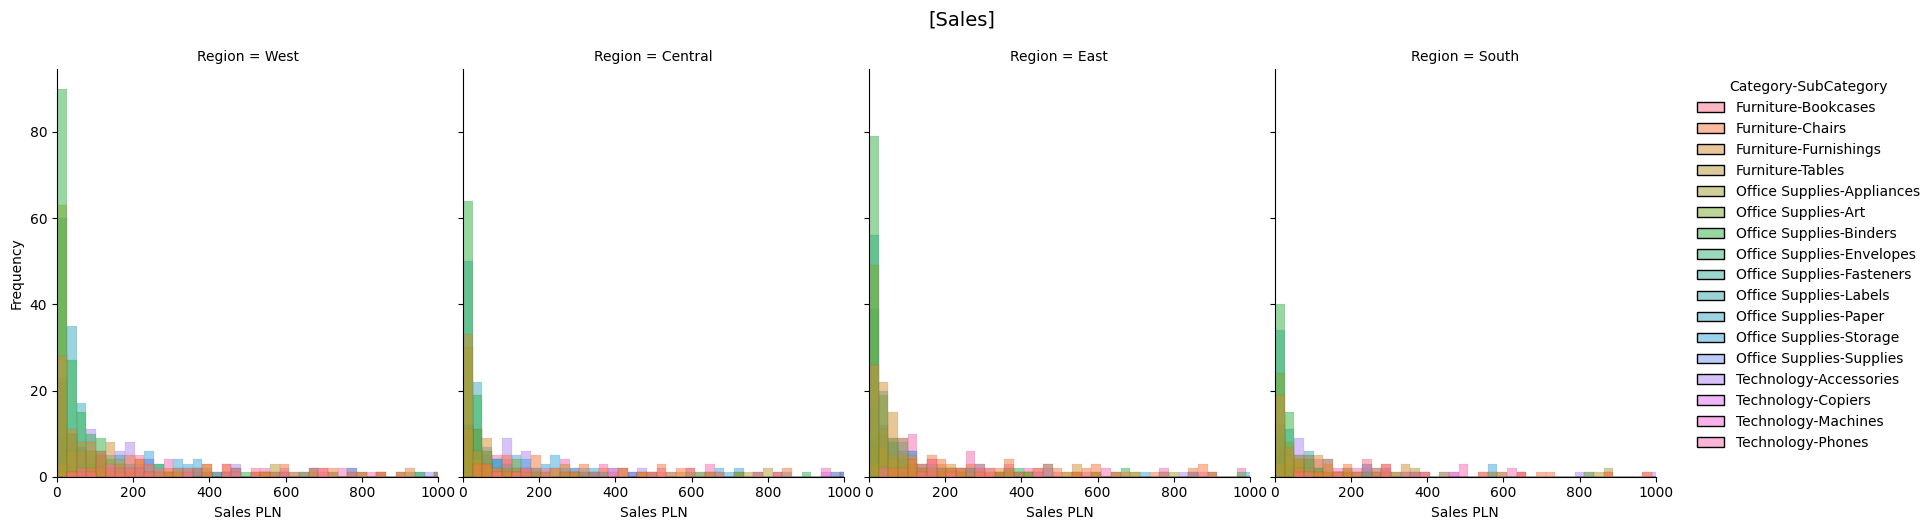

In [26]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Sales", hue="Category-SubCategory", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 1000), xlabel="Sales PLN", ylabel="Frequency")
g.fig.suptitle(f"[Sales]", fontsize=14, y=1.05)
# Show the plot
plt.show()

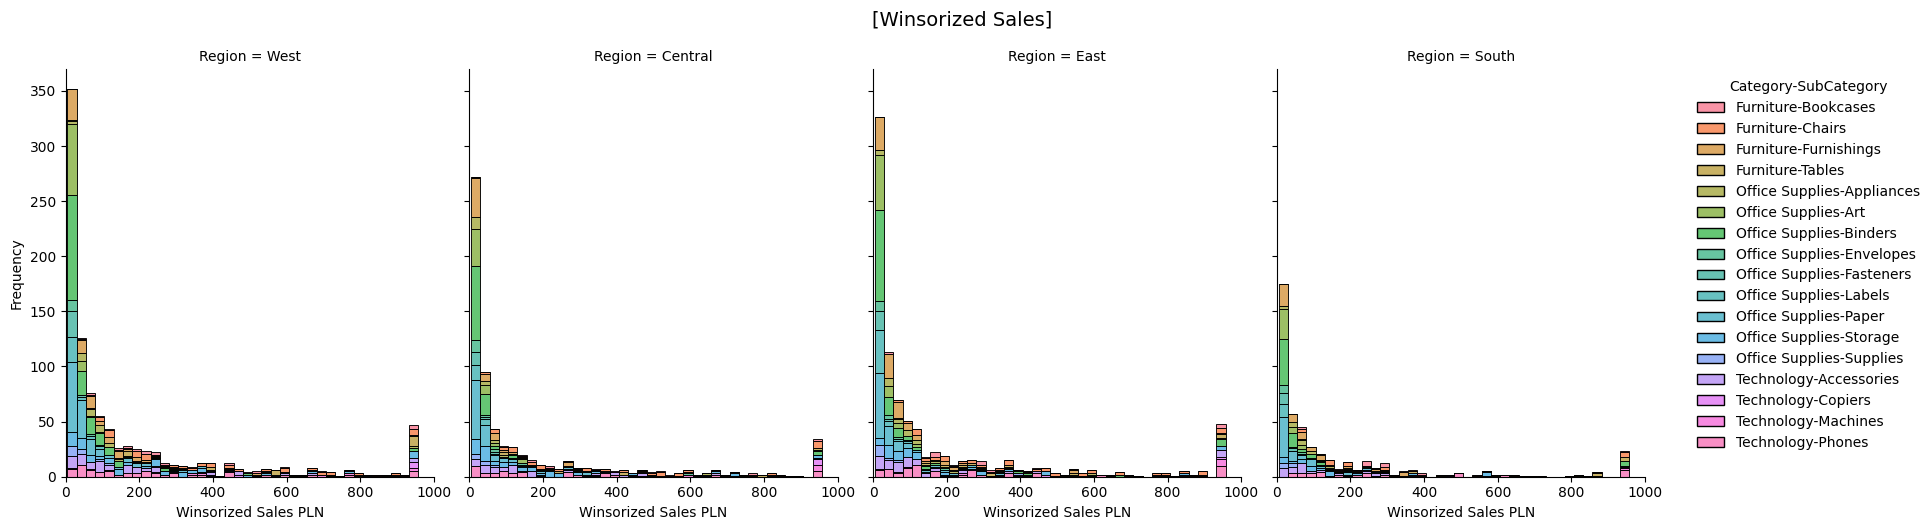

In [27]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Winsorized Sales", hue="Category-SubCategory", multiple="stack", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 1000), xlabel="Winsorized Sales PLN", ylabel="Frequency")
g.fig.suptitle(f"[Winsorized Sales]", fontsize=14, y=1.05)
# Show the plot
plt.show()

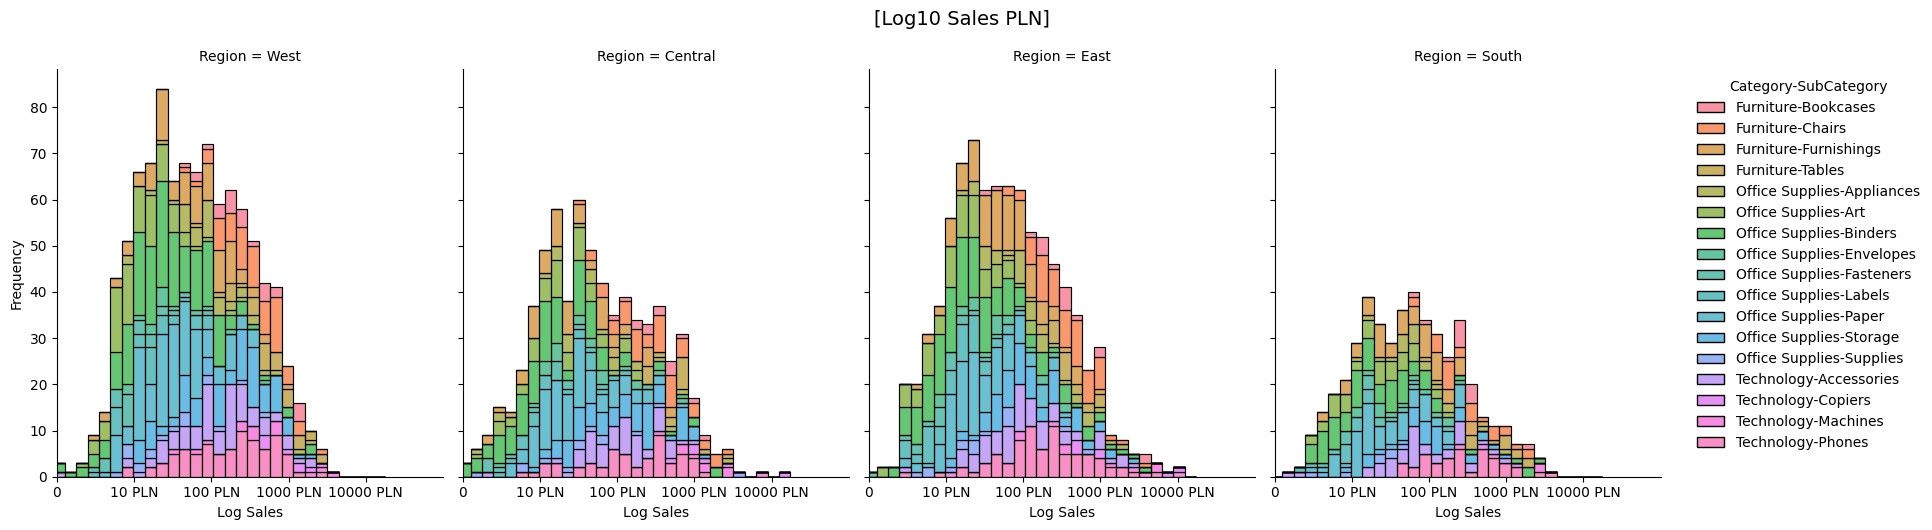

In [28]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Log Sales", hue="Category-SubCategory", multiple="stack", kde=False, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

# Set the x-axis ticks to [0, 10, 100, 1000]
g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
# g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

# Show the plot
plt.show()

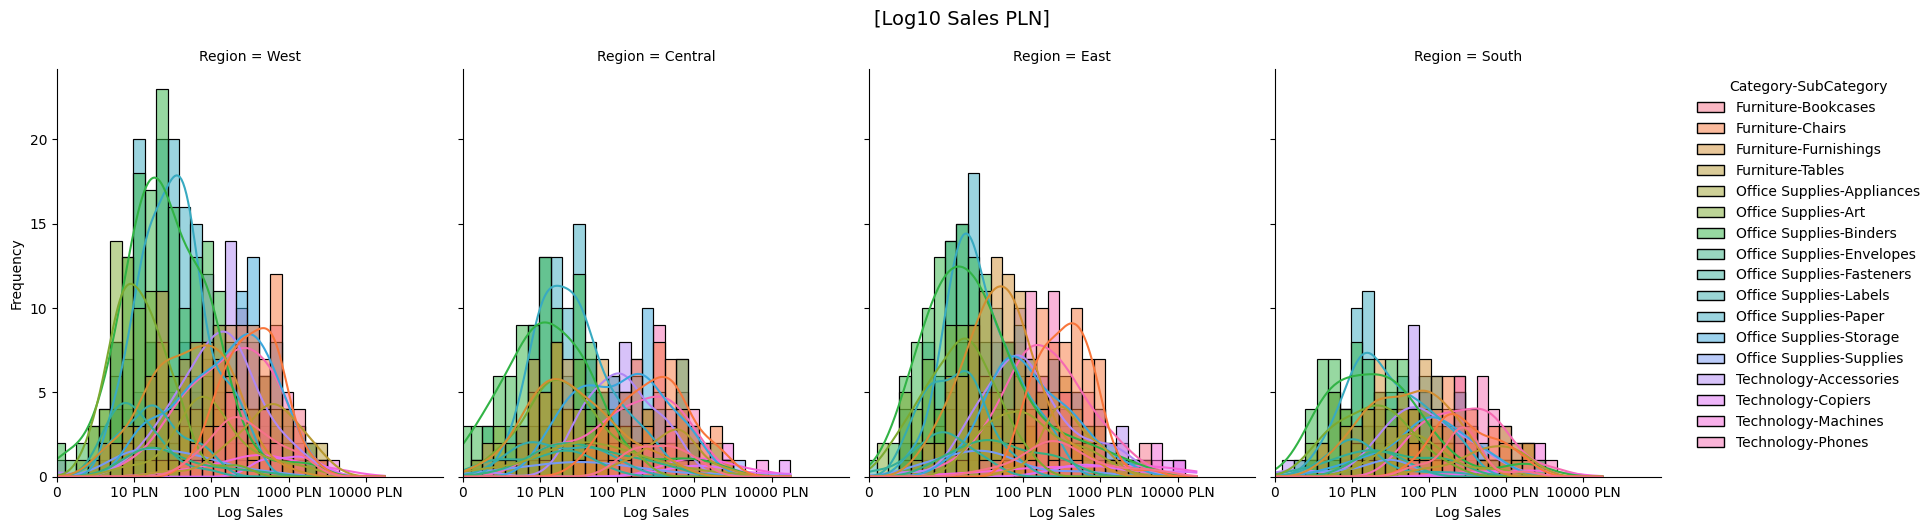

In [29]:
# Create a histogram with groupings based on Order Year
g = sns.displot(data=df_sample,
                x="Log Sales", hue="Category-SubCategory", kde=True, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

# Customize the plot
g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

# Set the x-axis ticks to [0, 10, 100, 1000]
g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
# g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

# Show the plot
plt.show()

0 Furniture-Bookcases


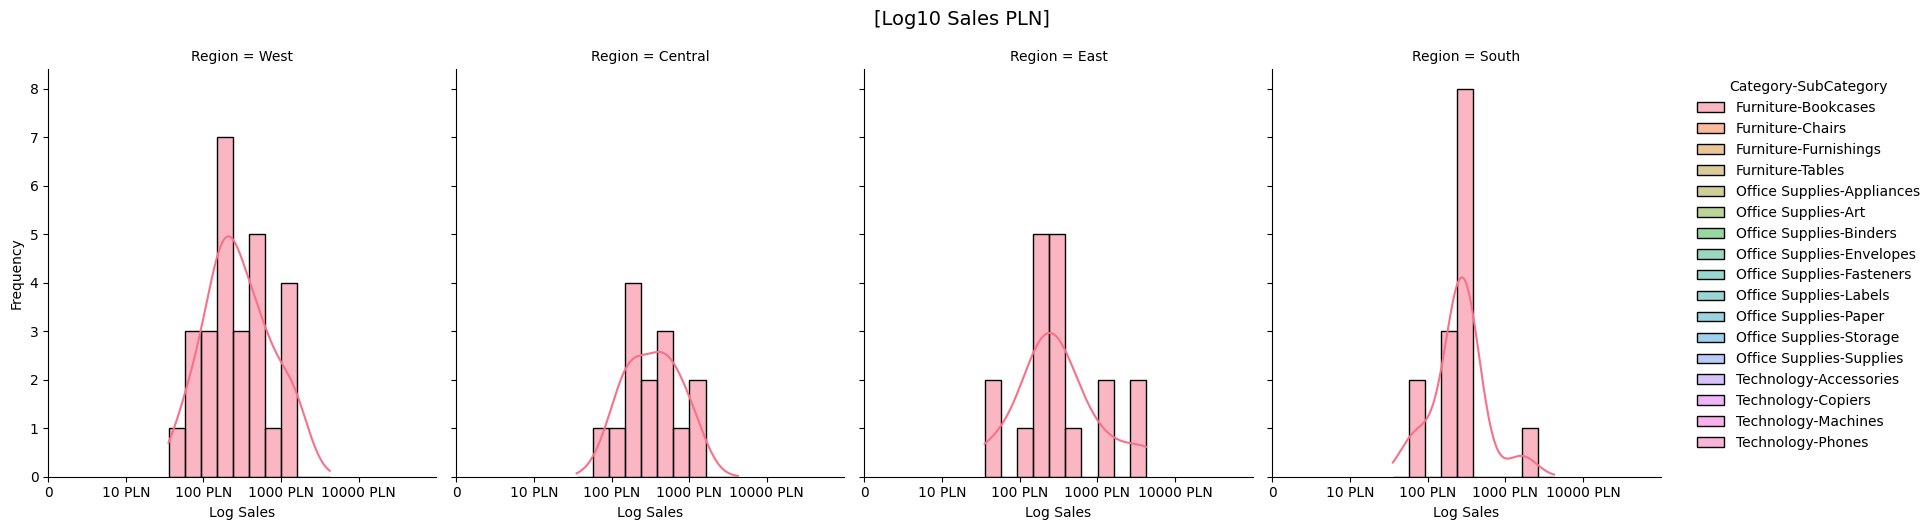

1 Furniture-Chairs


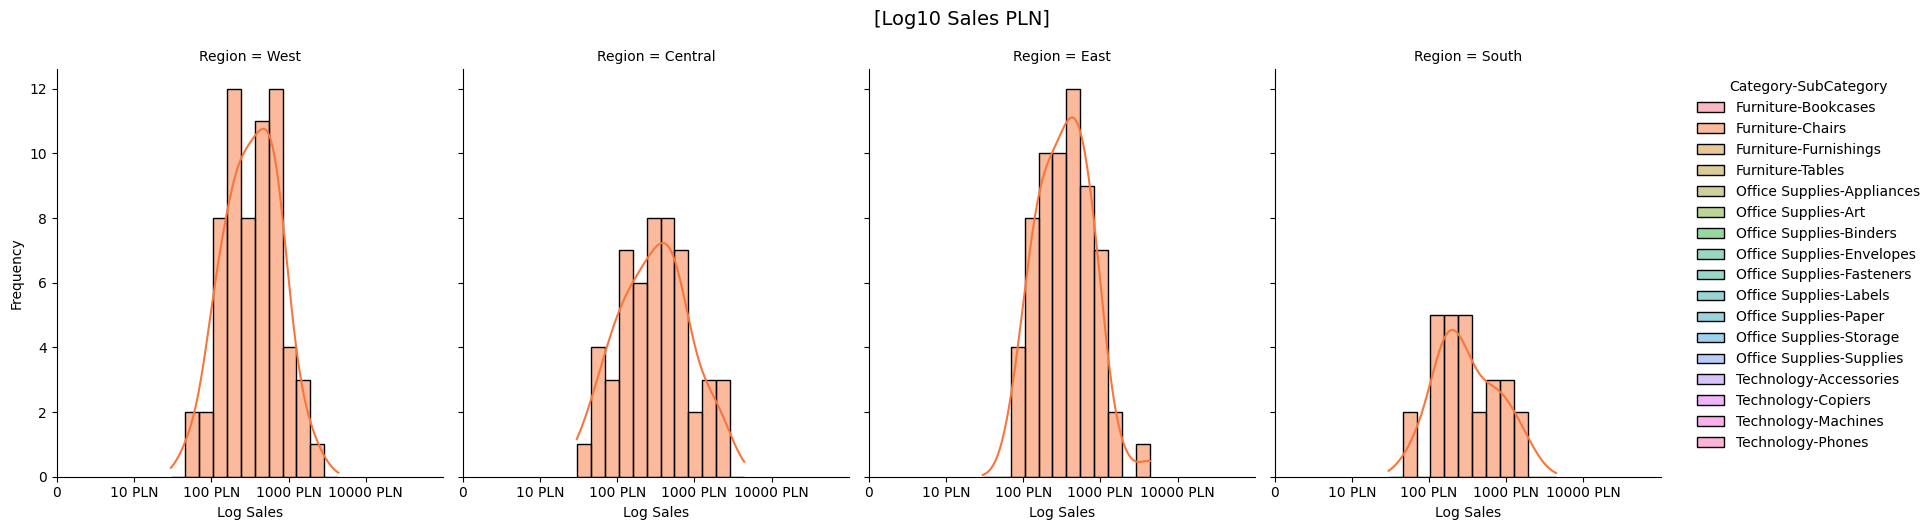

2 Office Supplies-Supplies


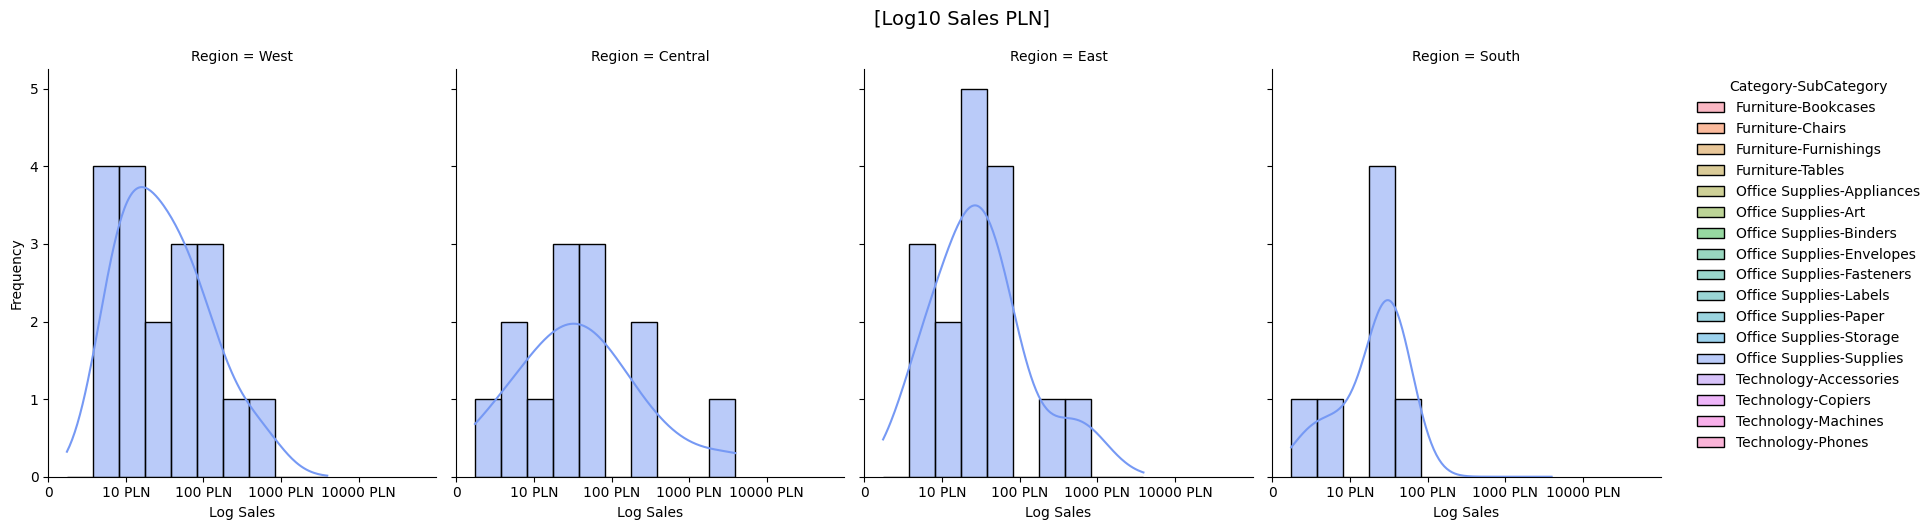

3 Office Supplies-Paper


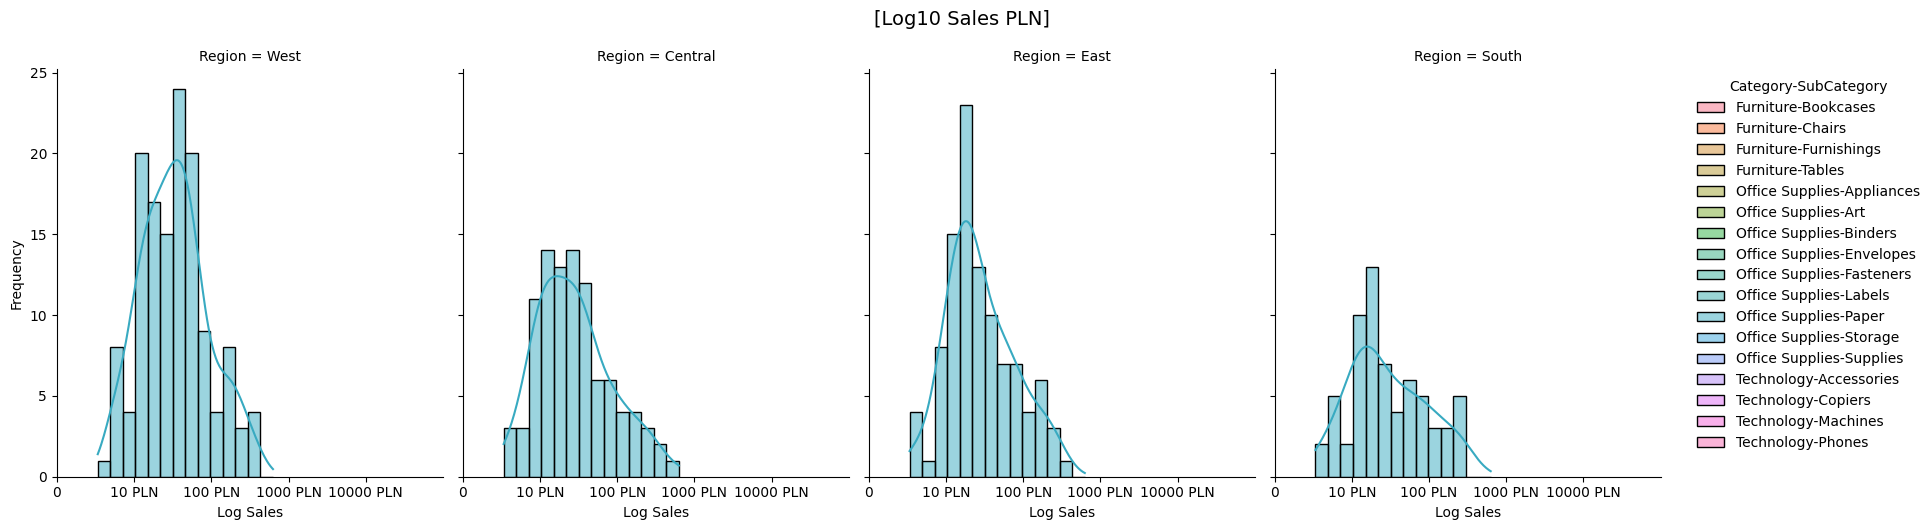

4 Office Supplies-Binders


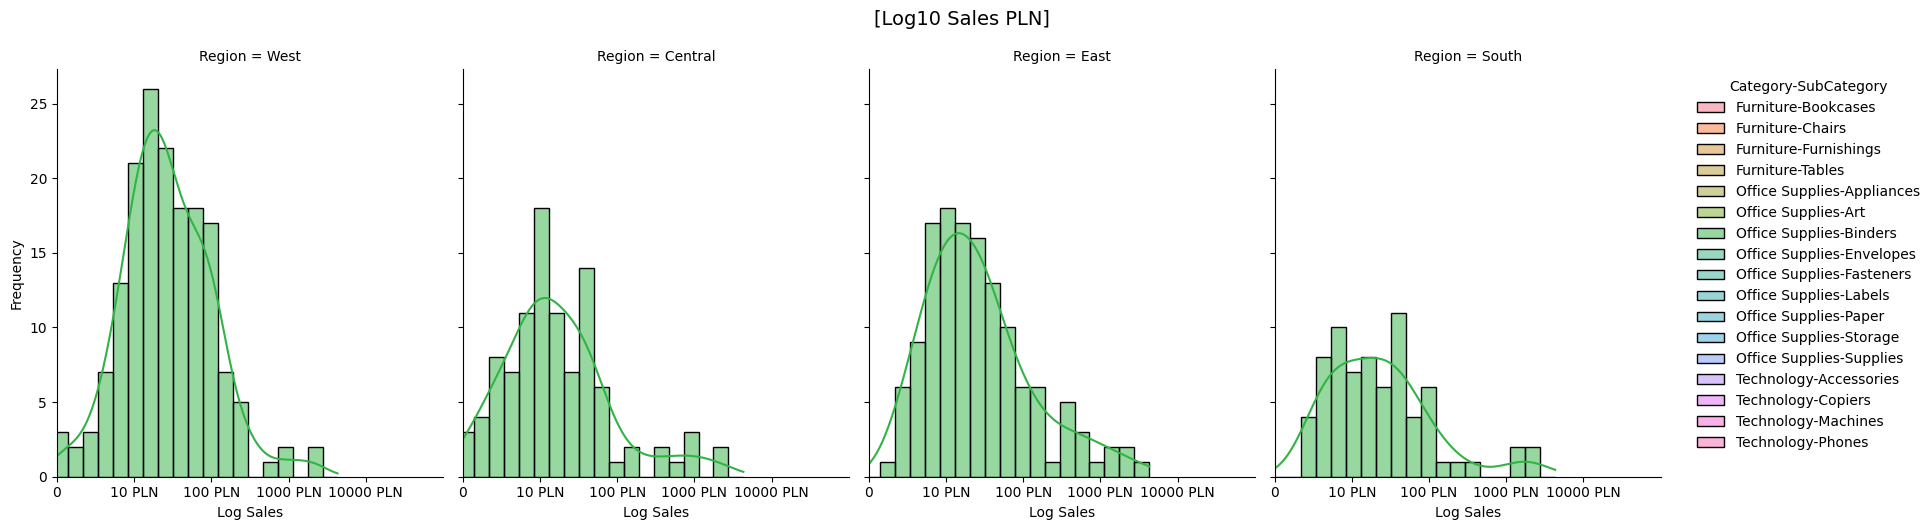

5 Technology-Phones


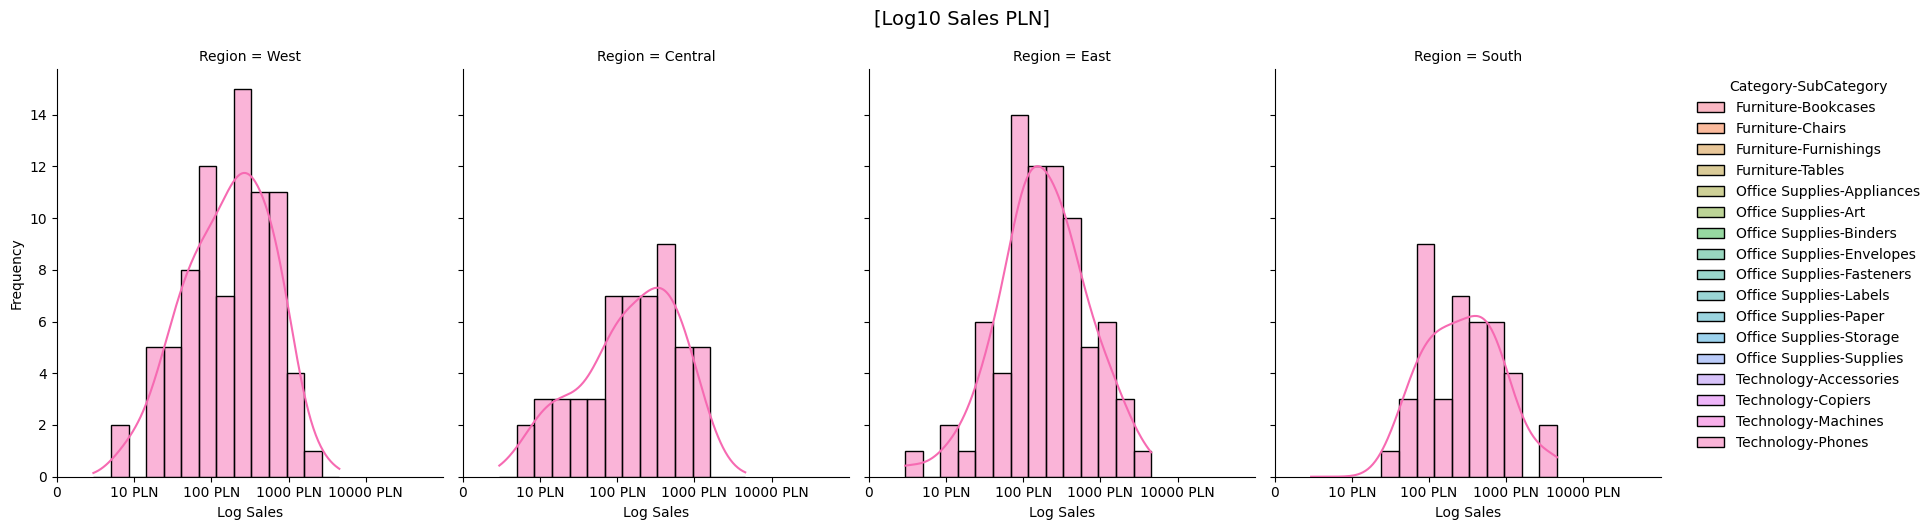

6 Technology-Accessories


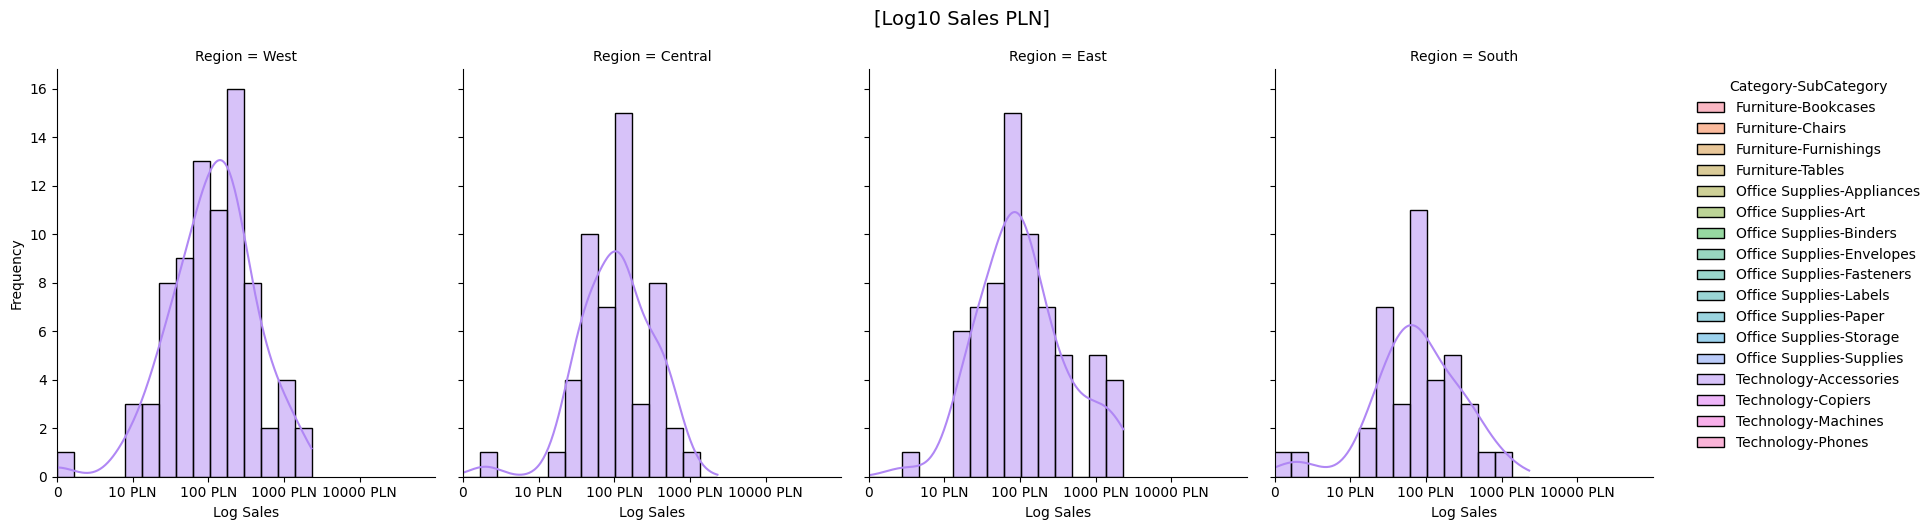

7 Furniture-Furnishings


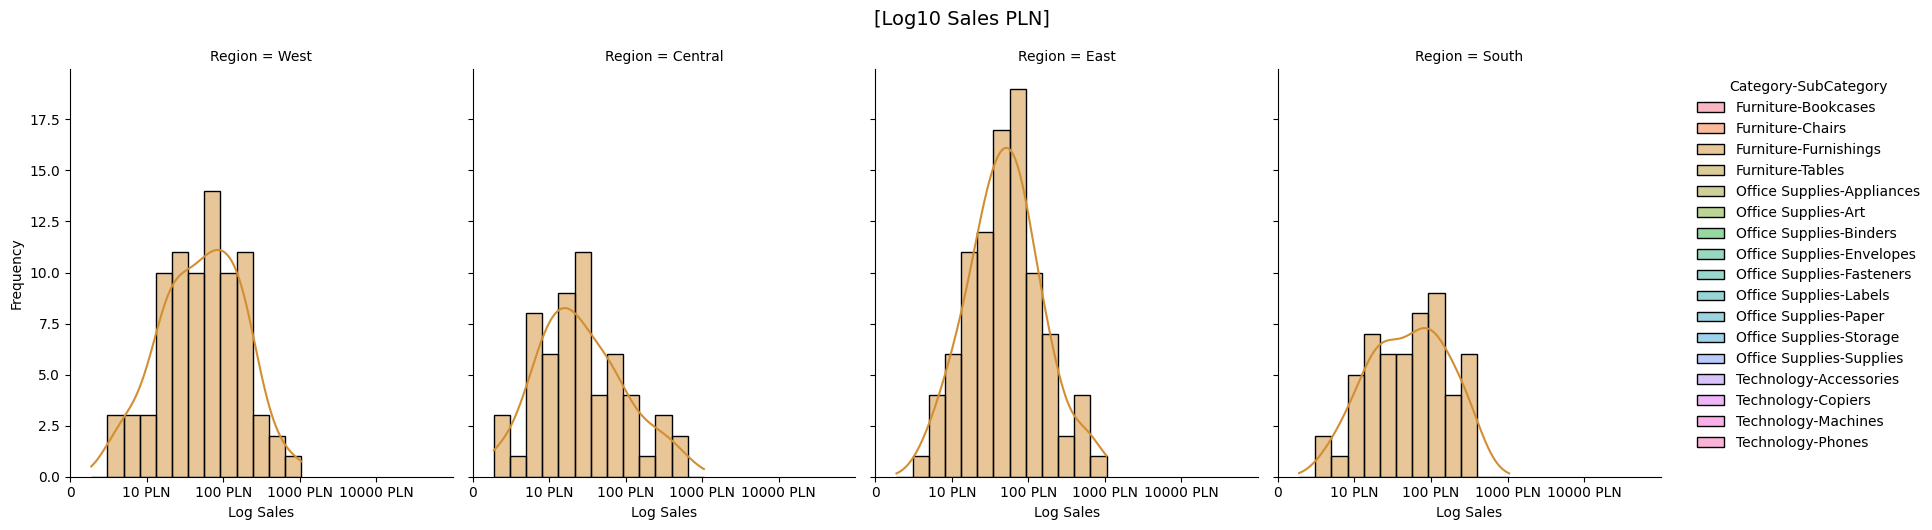

8 Office Supplies-Storage


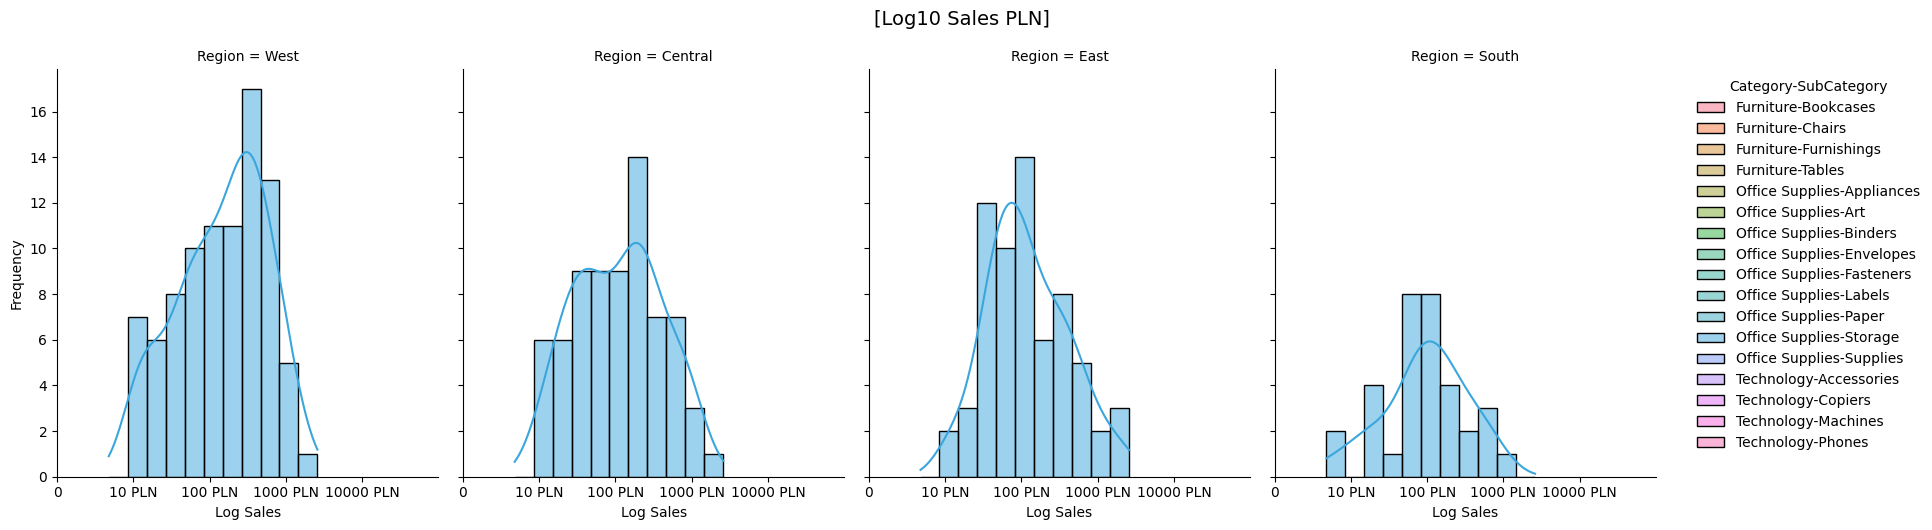

9 Furniture-Tables


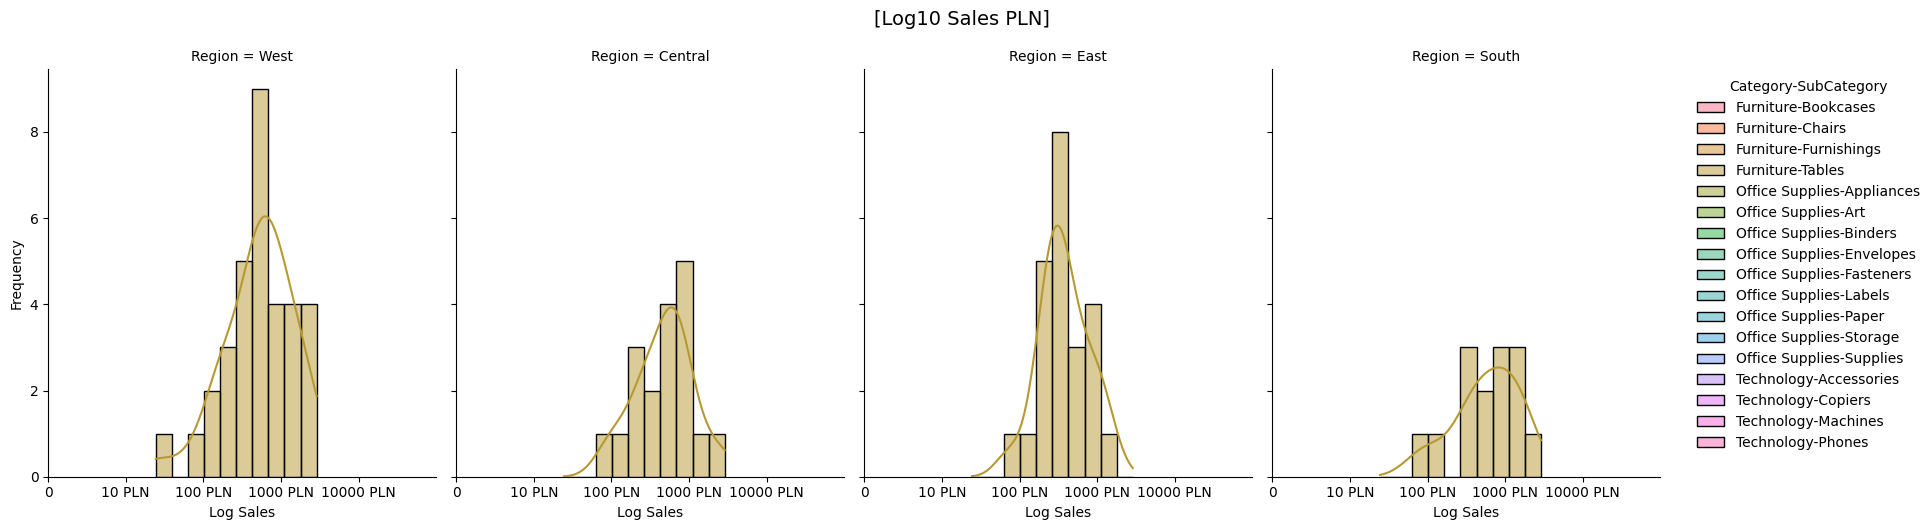

10 Office Supplies-Art


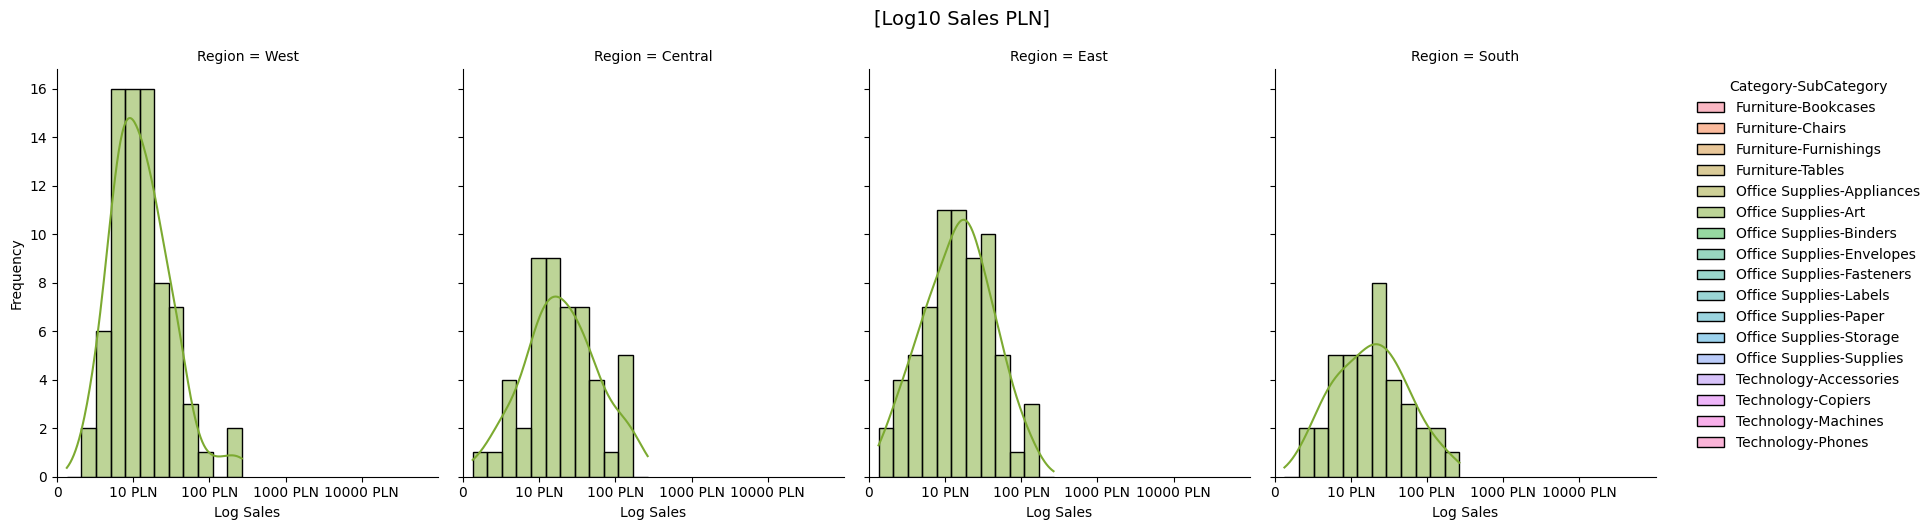

11 Office Supplies-Labels


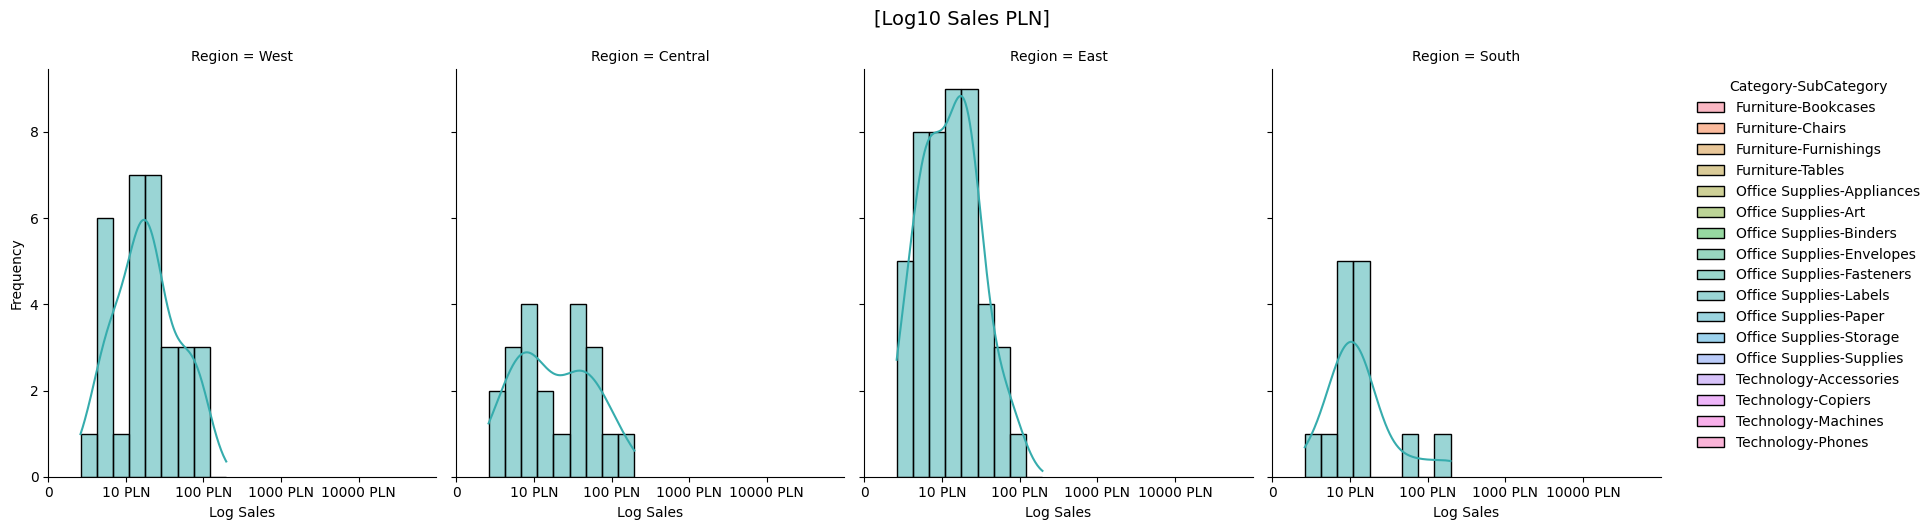

12 Office Supplies-Envelopes


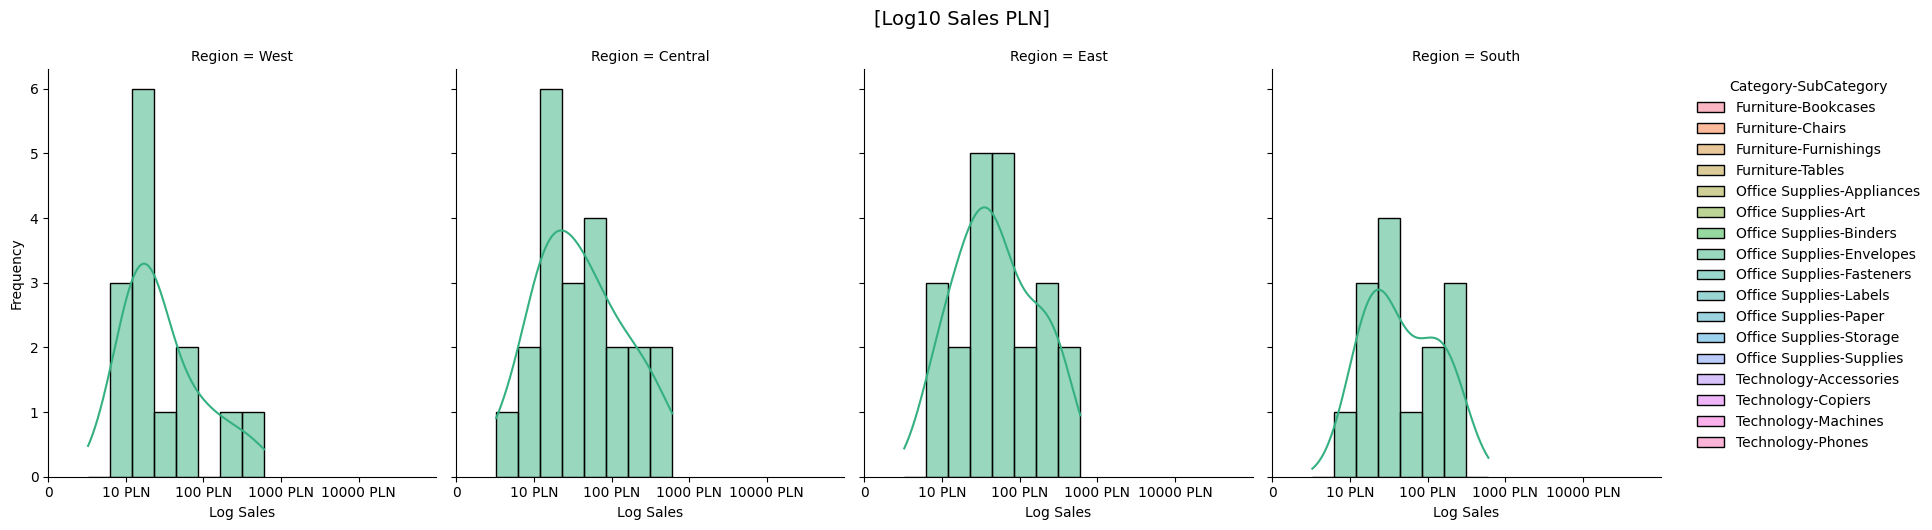

13 Office Supplies-Appliances


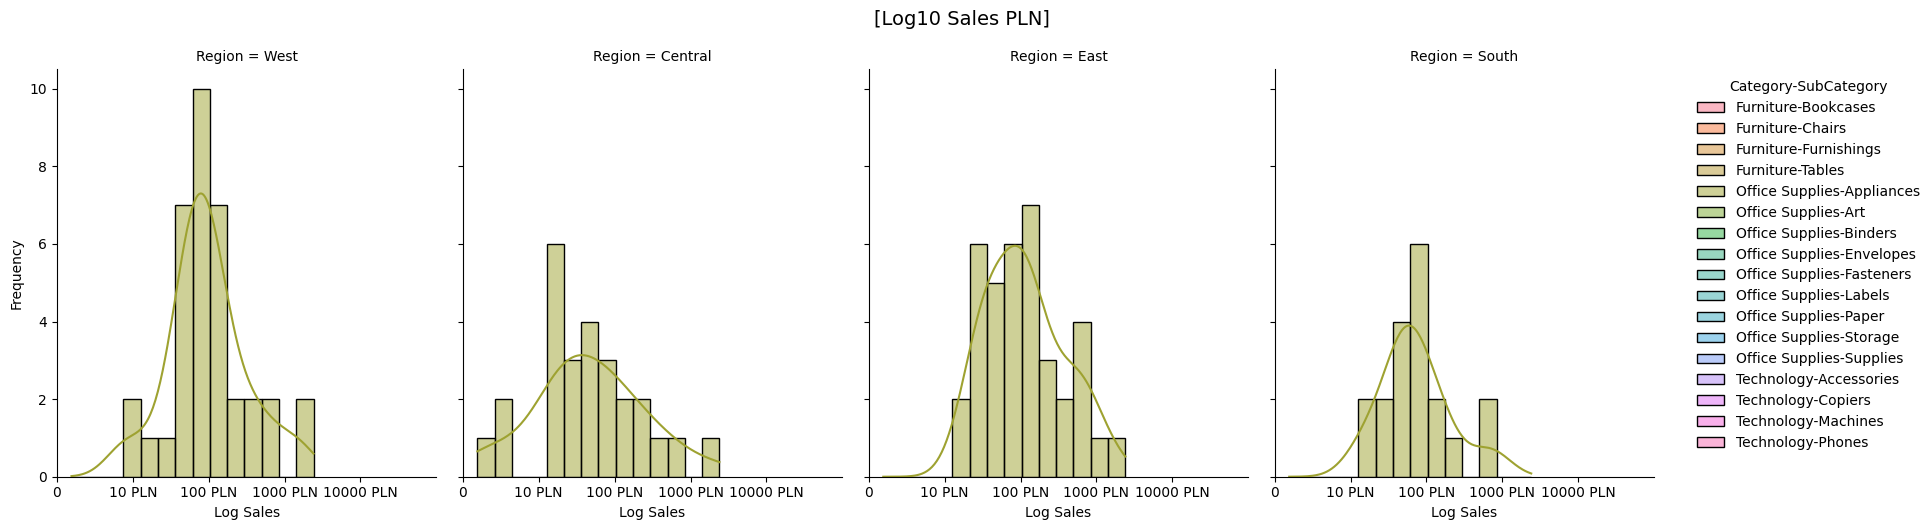

14 Technology-Copiers


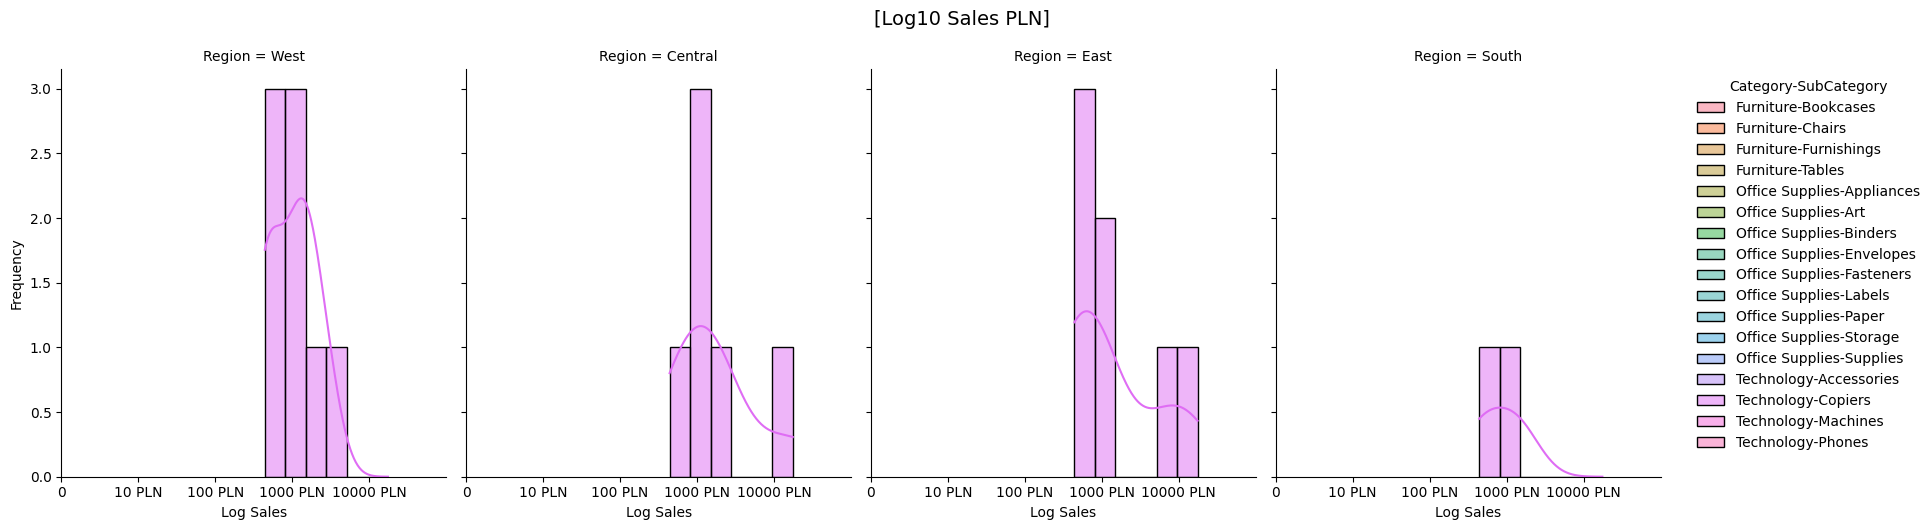

15 Office Supplies-Fasteners


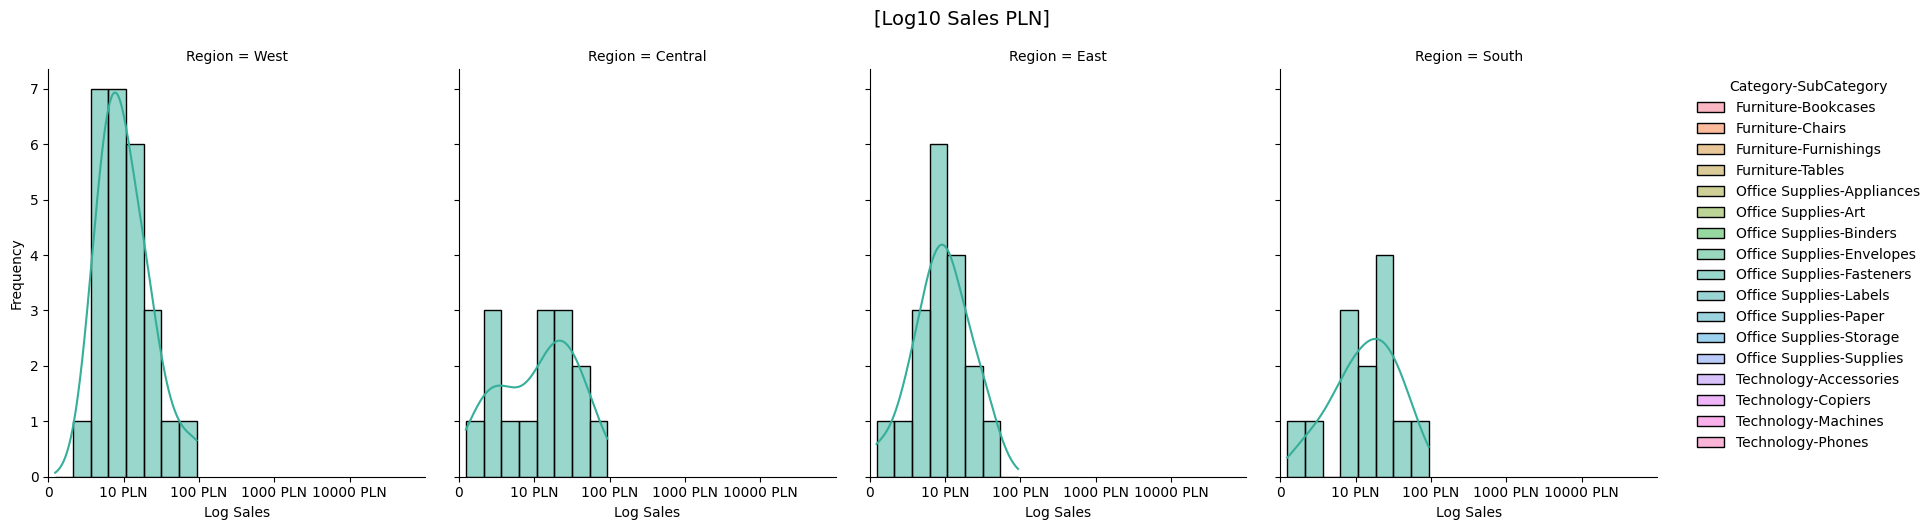

16 Technology-Machines


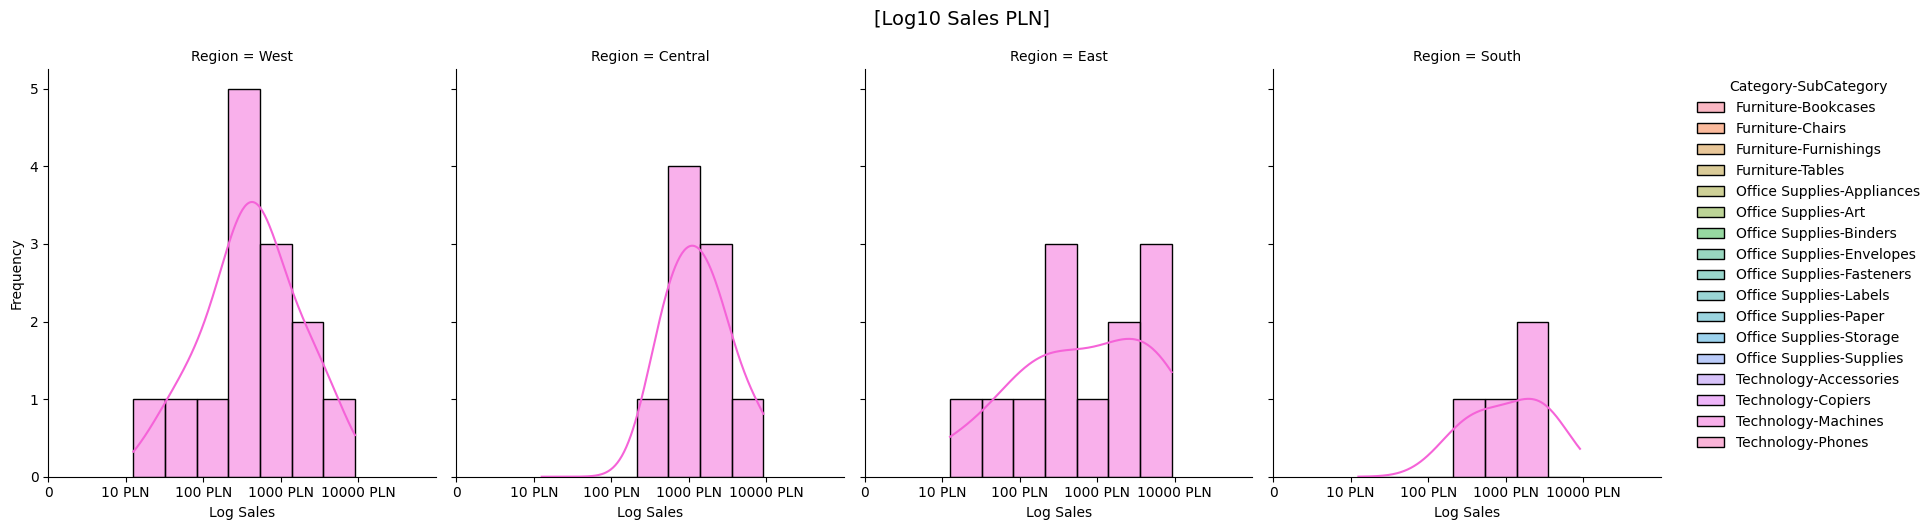

In [30]:
for c, cat in sorted(enumerate(df_sample["Category-SubCategory"].unique())):
    print(c, cat)
    # Create a histogram with groupings based on Order Year
    g = sns.displot(data=df_sample[df_sample["Category-SubCategory"] == cat],
                    x="Log Sales", hue="Category-SubCategory", kde=True, hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85)

    # Customize the plot
    g.set(xlim=(0, 5), xlabel="Log Sales", ylabel="Frequency")
    g.fig.suptitle(f"[Log10 Sales PLN]", fontsize=14, y=1.05)

    # Set the x-axis ticks to [0, 10, 100, 1000]
    g.set(xticks=[0, 1, 2, 3, 4], xticklabels=["0", "10 PLN", "100 PLN", "1000 PLN", "10000 PLN"])
    # g.axes[0][0].xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Show the plot
    plt.show()

# BOX PLOTS

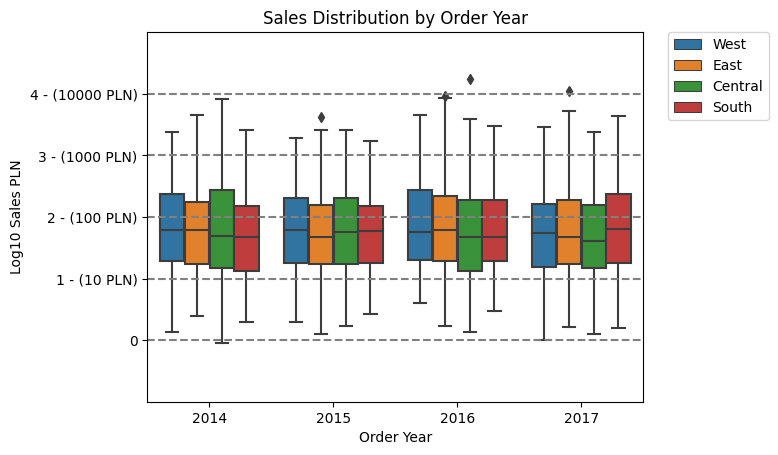

In [31]:
# Define the order of years
year_order = sorted(df_sample["Order Year"].unique())

# Create a box plot with groupings based on Order Year
g = sns.boxplot(data=df_sample, x="Order Year", y="Log Sales", hue="Region", order=year_order)

# Customize the plot
g.set(ylim=(-1, 5), xlabel="Order Year", ylabel="Log10 Sales PLN", title="Sales Distribution by Order Year")

g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
# Move the legend outside the chart box
# Add horizontal lines at each ytick
yticks = plt.yticks()[0]
for ytick in yticks:
    plt.axhline(ytick, color='gray', linestyle='--')

# Move the legend outside the chart box
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

2014
2015
2016
2017


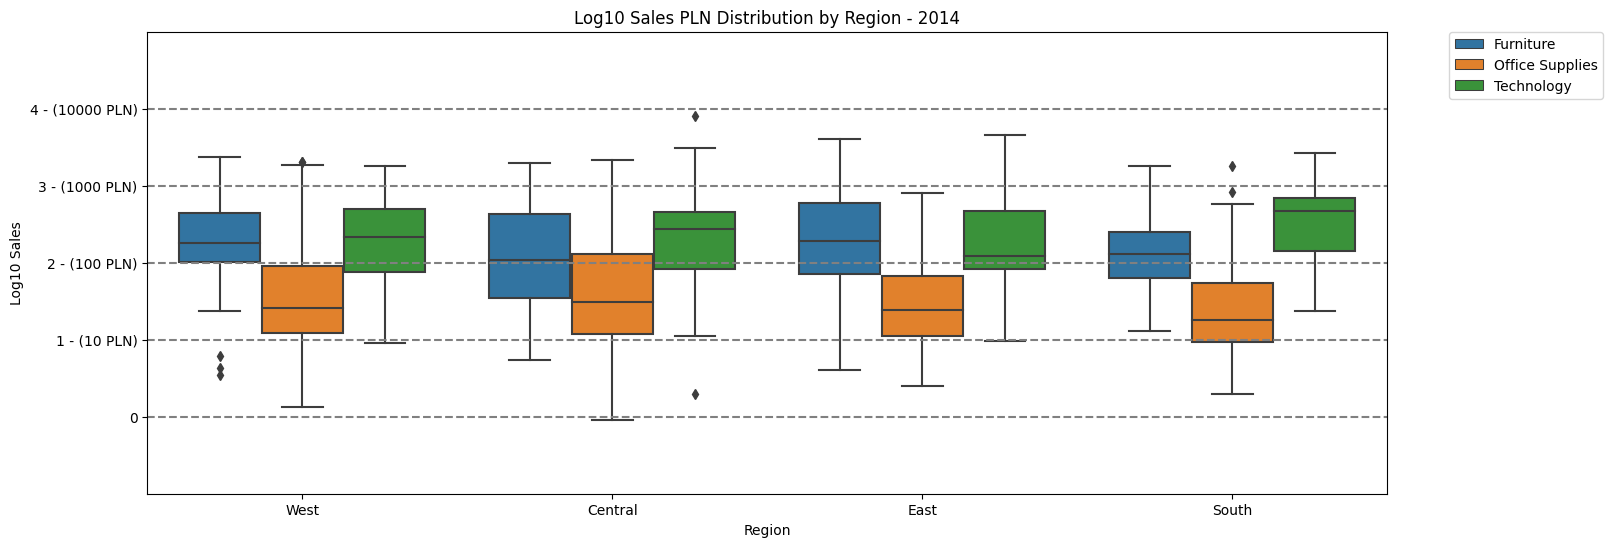

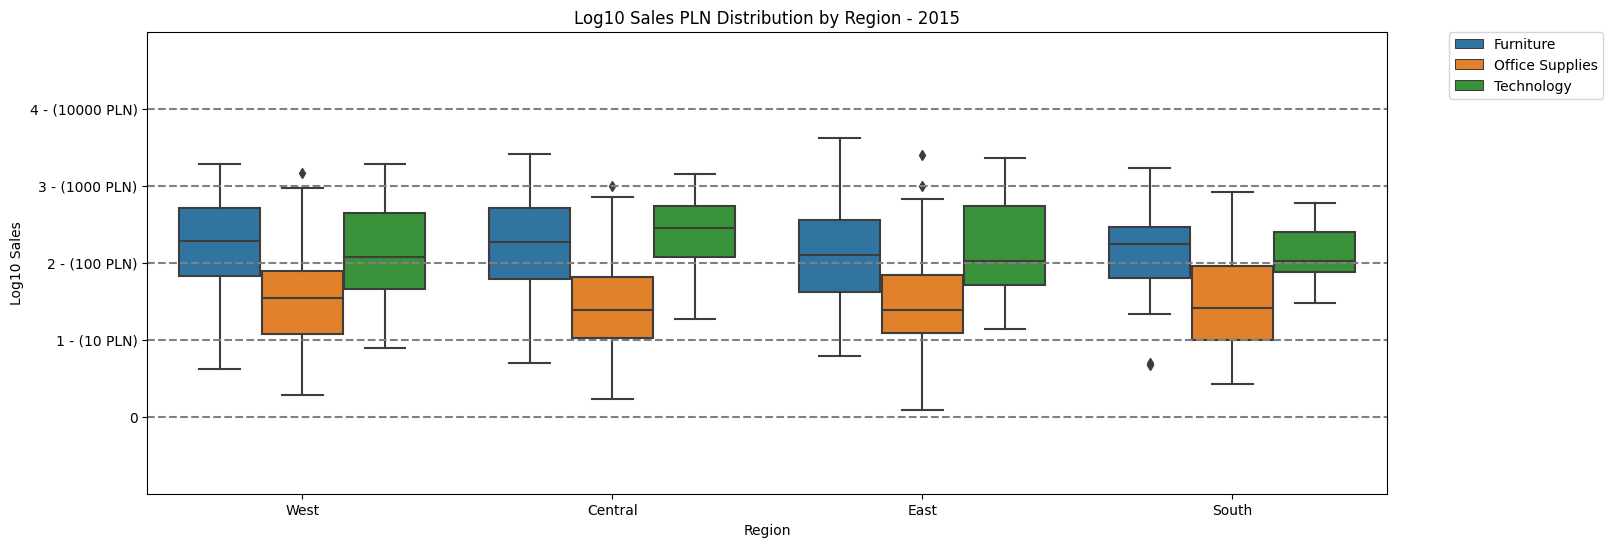

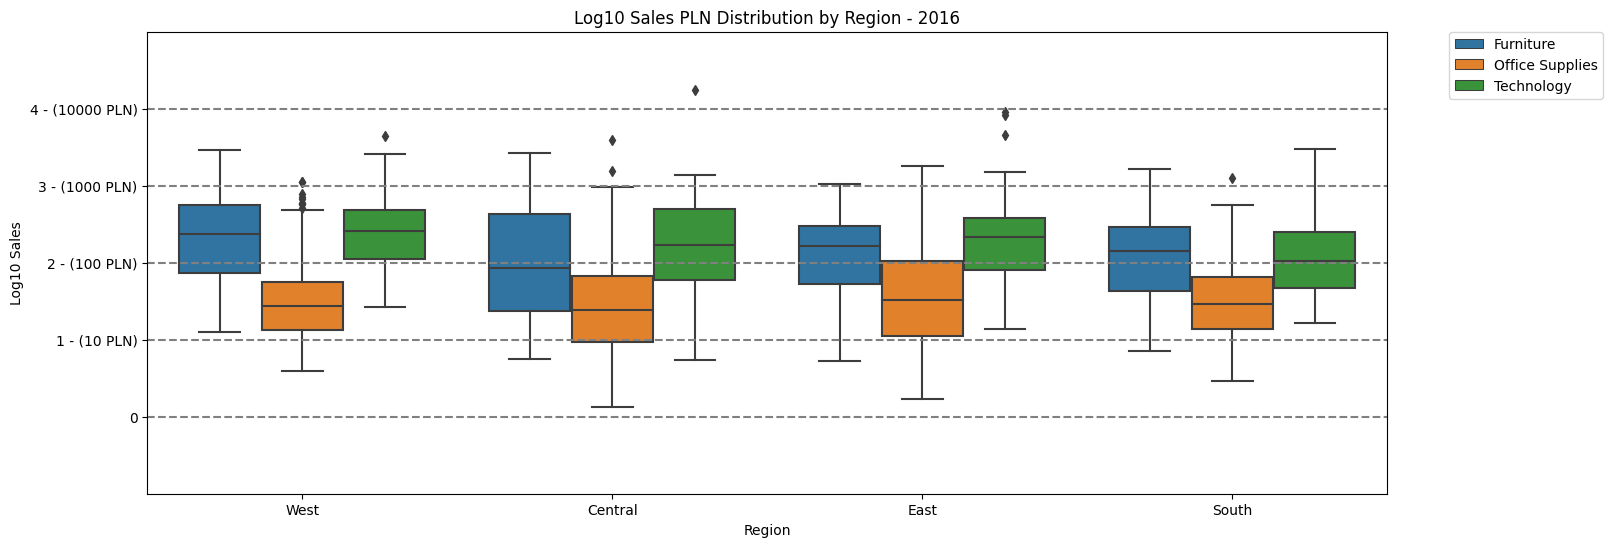

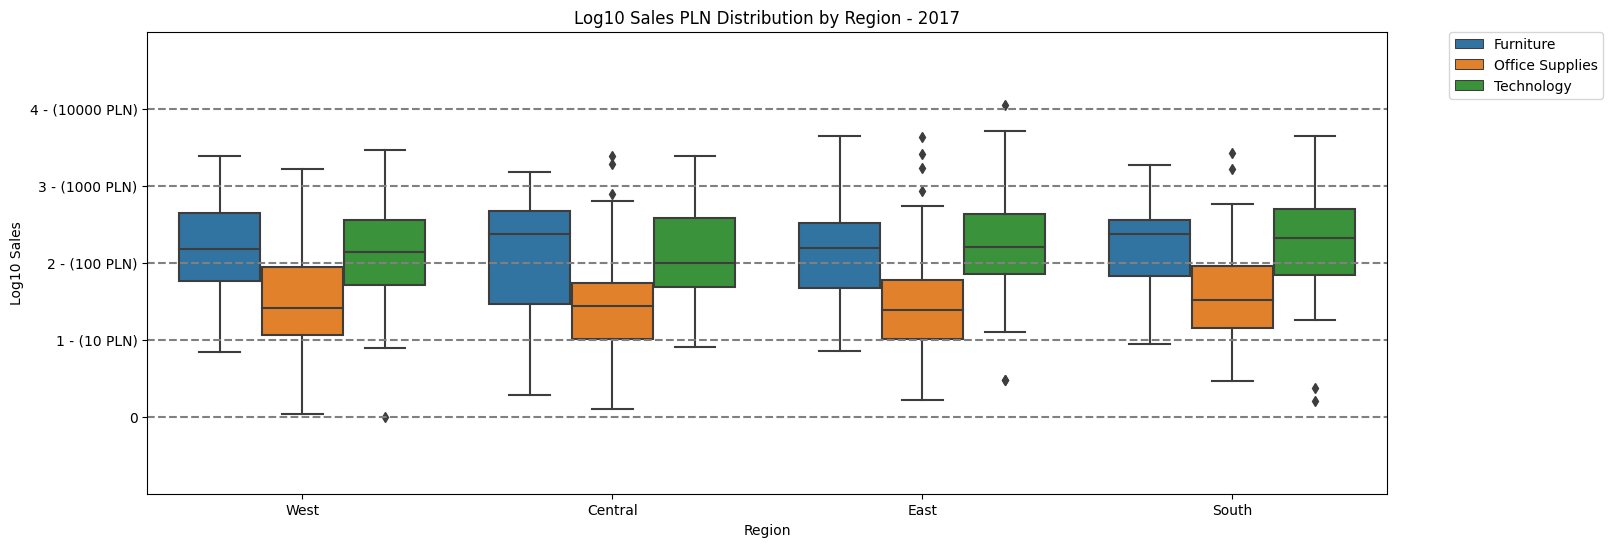

In [32]:
# # Define the order of years
# year_order = sorted(df_sample["Order Year"].unique())
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    
    # Set the figure size
    plt.figure(figsize=(16, 6))

    # Create a box plot with groupings based on Order Year
    g = sns.boxplot(data=df_sample[df_sample["Order Year"] == v], x="Region", y="Log Sales", hue="Category", order=COL_ORDER, hue_order=X_ORDER)

    # Customize the plot
    g.set(ylim=(-1, 5), xlabel="Region", ylabel="Log10 Sales", title=f"Log10 Sales PLN Distribution by Region - {v}")
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Add horizontal lines at each ytick
    yticks = plt.yticks()[0]
    for ytick in yticks:
        plt.axhline(ytick, color='gray', linestyle='--')
    # Move the legend outside the chart box
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

2014
2015
2016
2017


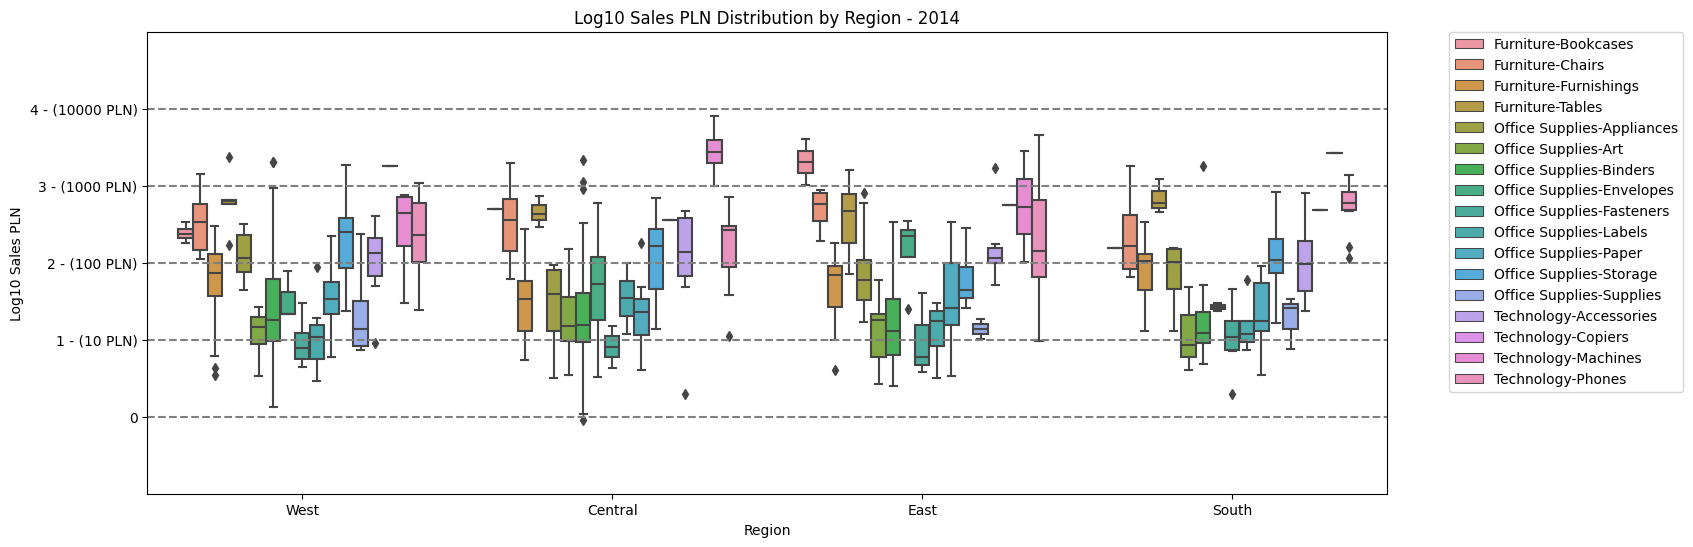

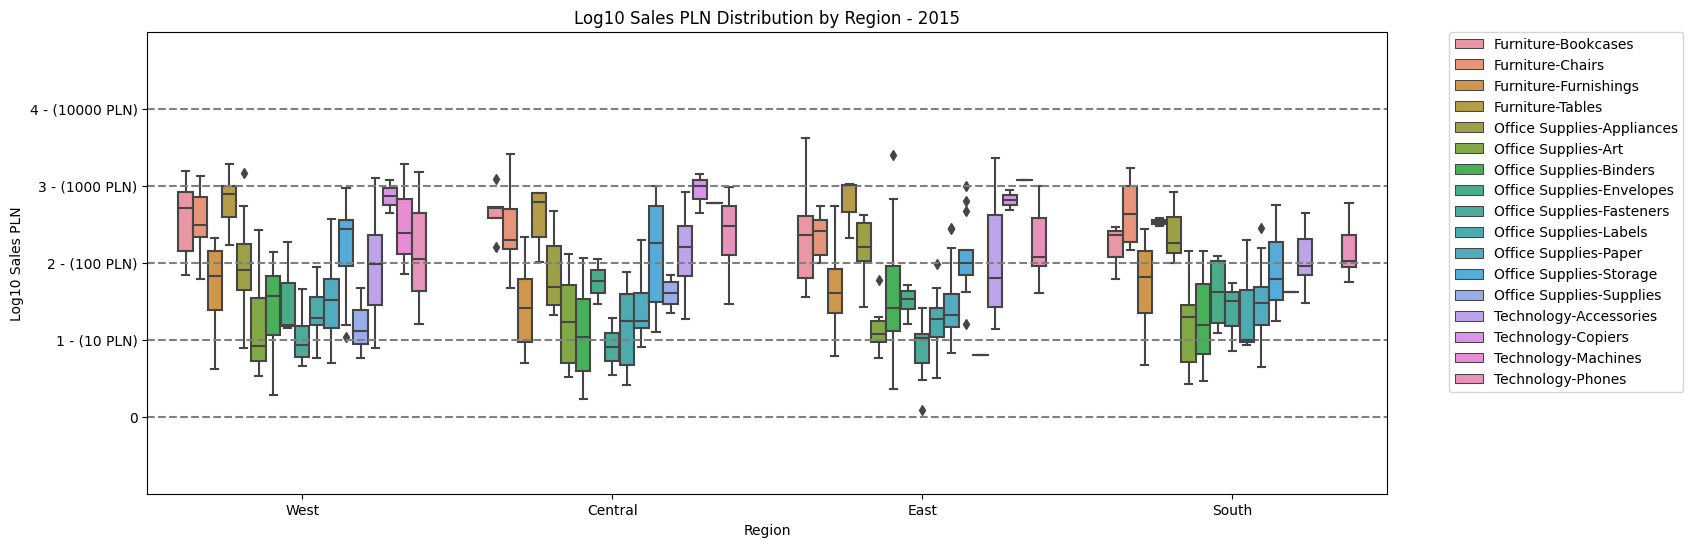

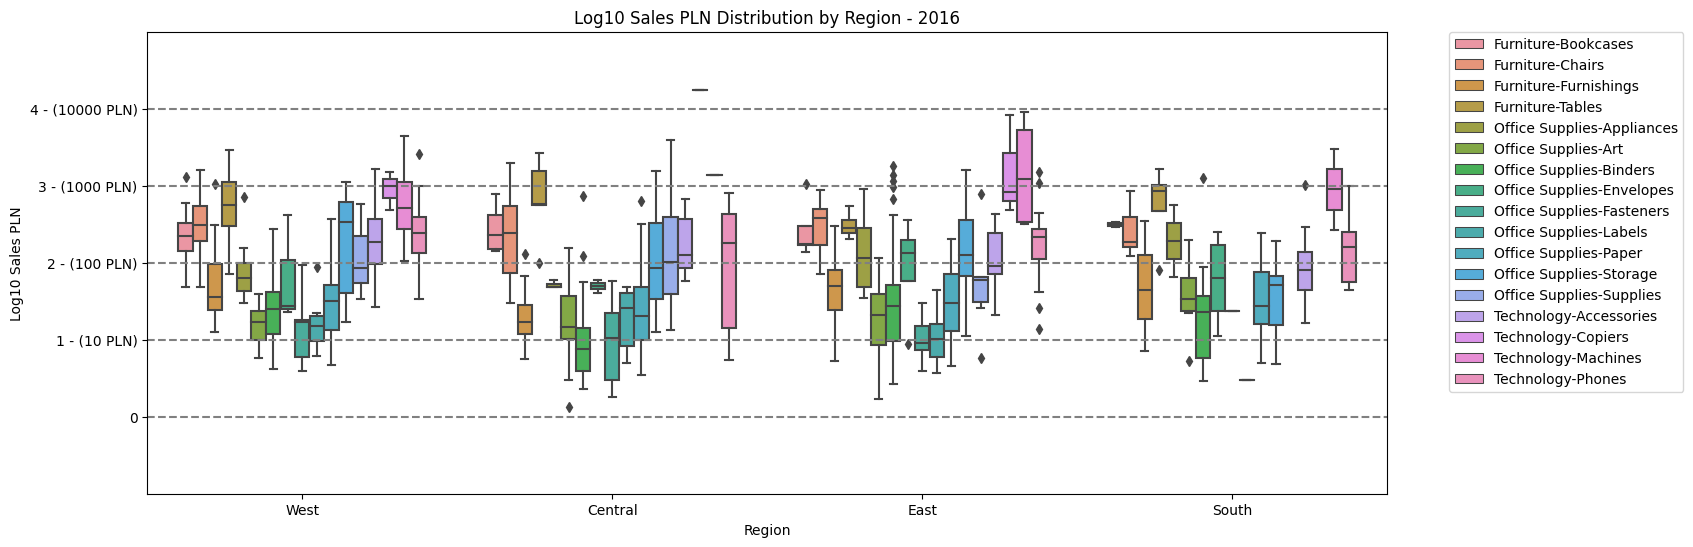

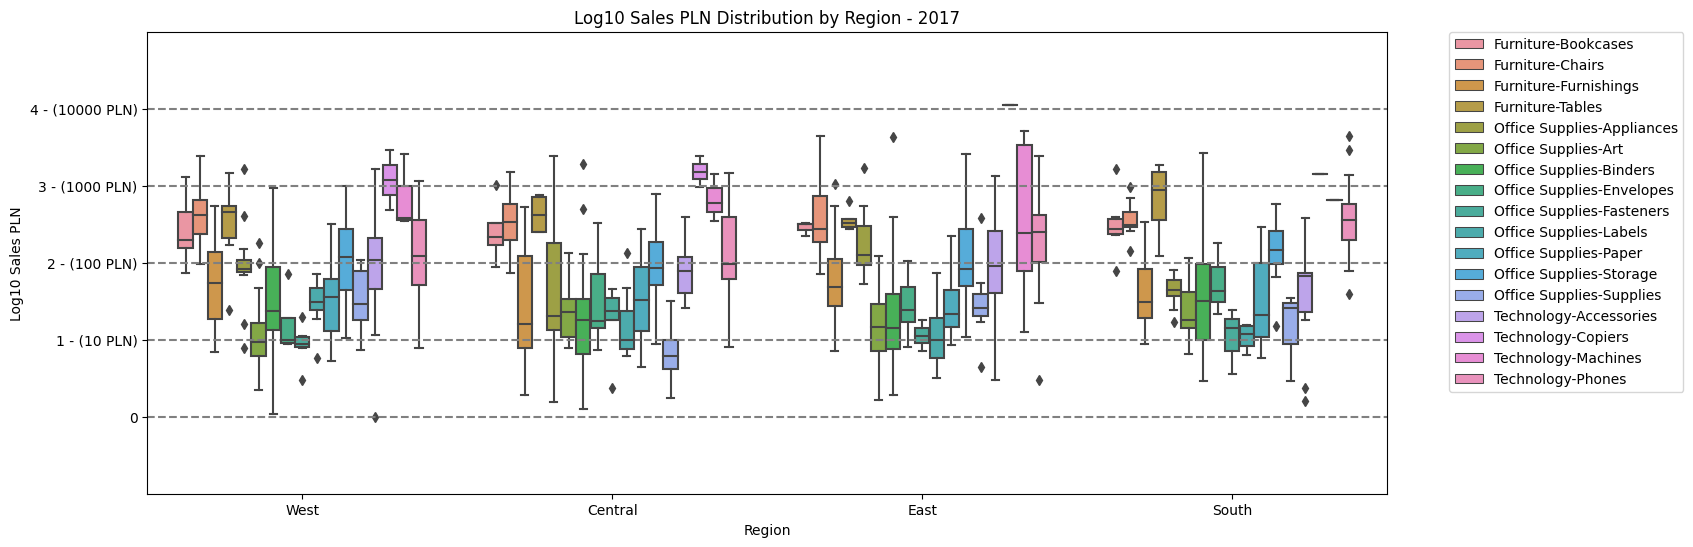

In [33]:
# # Define the order of years
# year_order = sorted(df_sample["Order Year"].unique())
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    
    # # Define the order of years
    # year_order = sorted(df_sample["Order Year"].unique())

    # Set the figure size
    plt.figure(figsize=(16, 6))

    # Create a box plot with groupings based on Order Year
    g = sns.boxplot(data=df_sample[df_sample["Order Year"] == v], x="Region", y="Log Sales", hue="Category-SubCategory", order=COL_ORDER, hue_order=HUE_ORDER)

    # Customize the plot
    g.set(ylim=(-1, 5), xlabel="Region", ylabel="Log10 Sales PLN", title=f"Log10 Sales PLN Distribution by Region - {v}")
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Move the legend outside the chart box
    # Add horizontal lines at each ytick
    yticks = plt.yticks()[0]
    for ytick in yticks:
        plt.axhline(ytick, color='gray', linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# SWARM PLOTS

## Winsorized Sales

Text(0.5, 1.05, '[Winsorized Sales]')

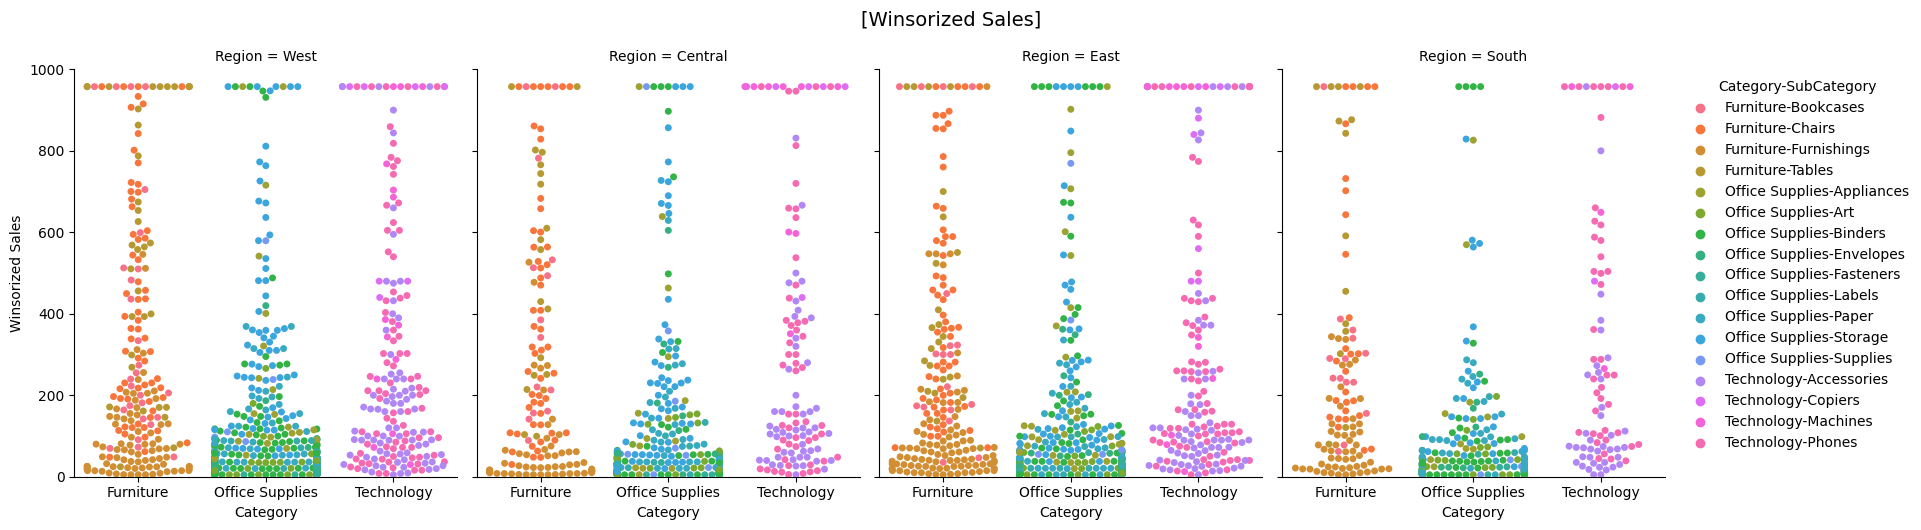

In [34]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Winsorized Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
)
g.set(ylim=(0, 1000))
g.fig.suptitle(f"[Winsorized Sales]", fontsize=14, y=1.05)

2014
2015
2016
2017


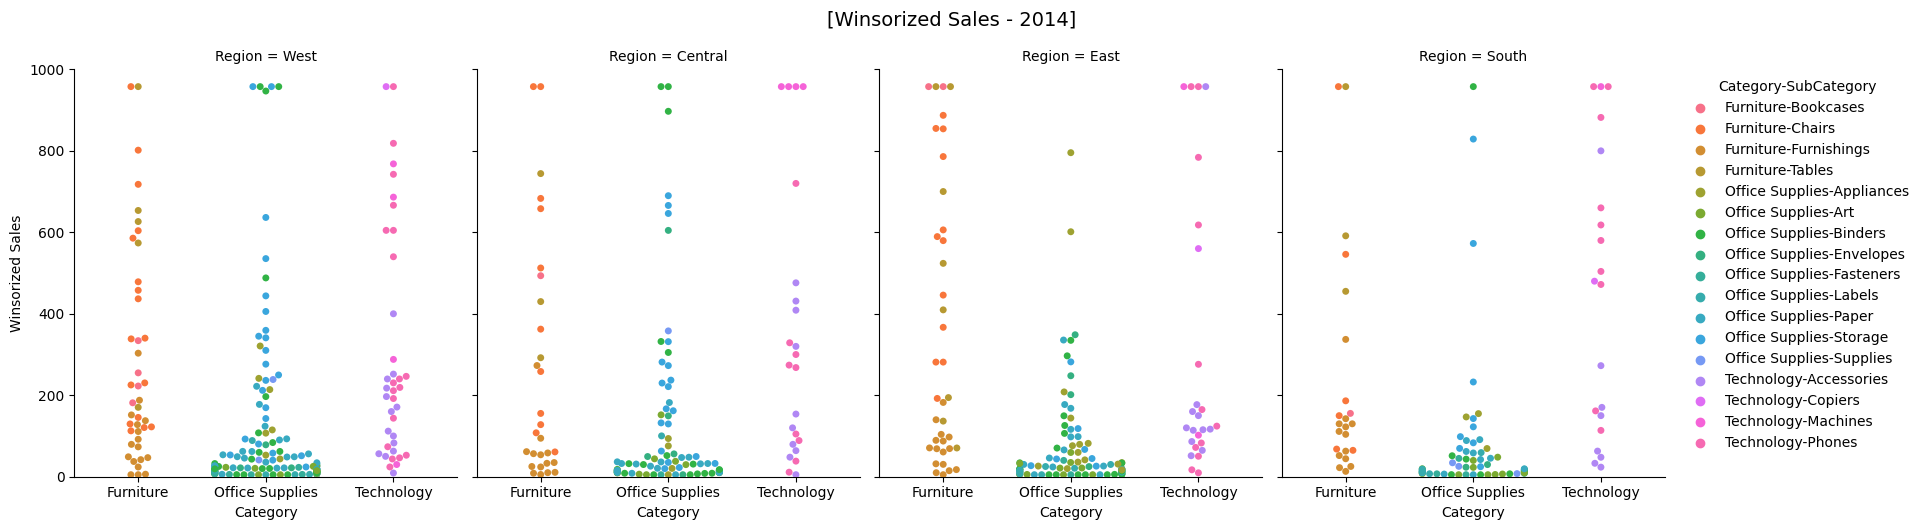

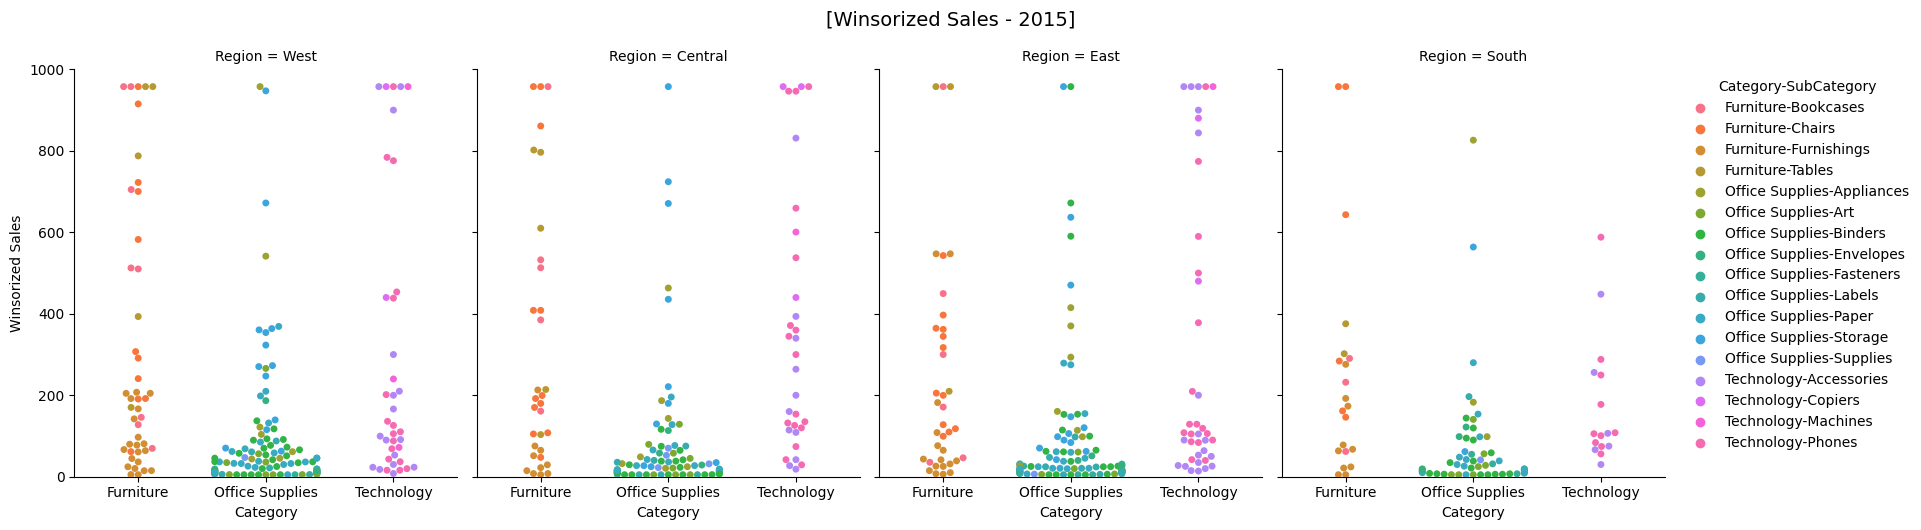

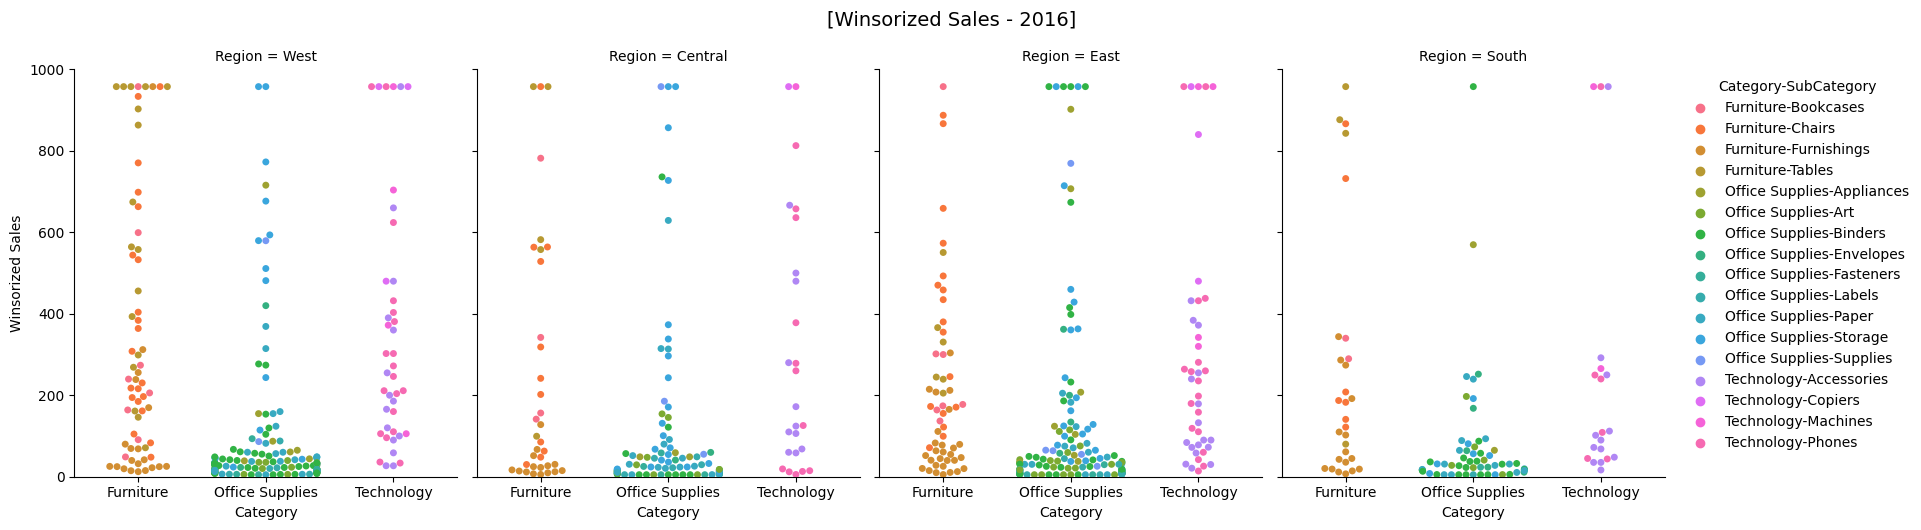

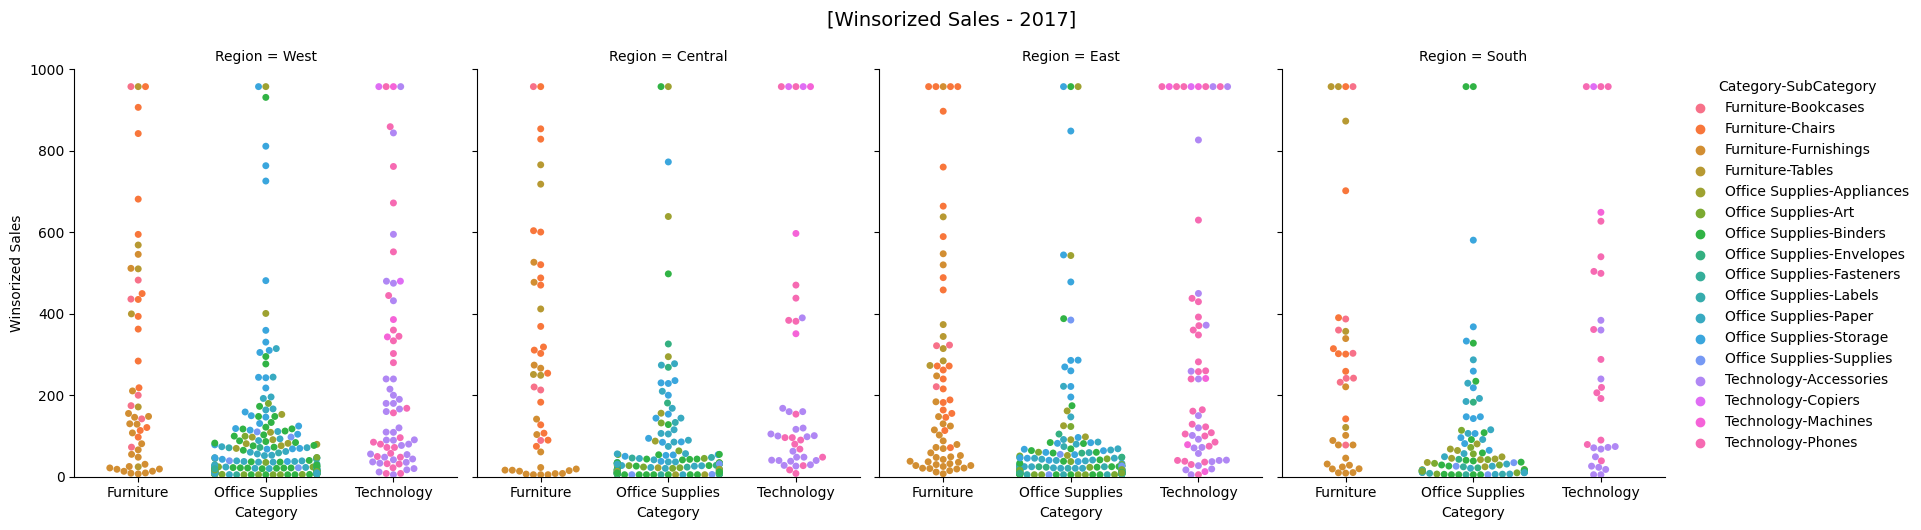

In [35]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Winsorized Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
    )
    g.set(ylim=(0, 1000))
    g.fig.suptitle(f"[Winsorized Sales - {v}]", fontsize=14, y=1.05)

## Log Sales

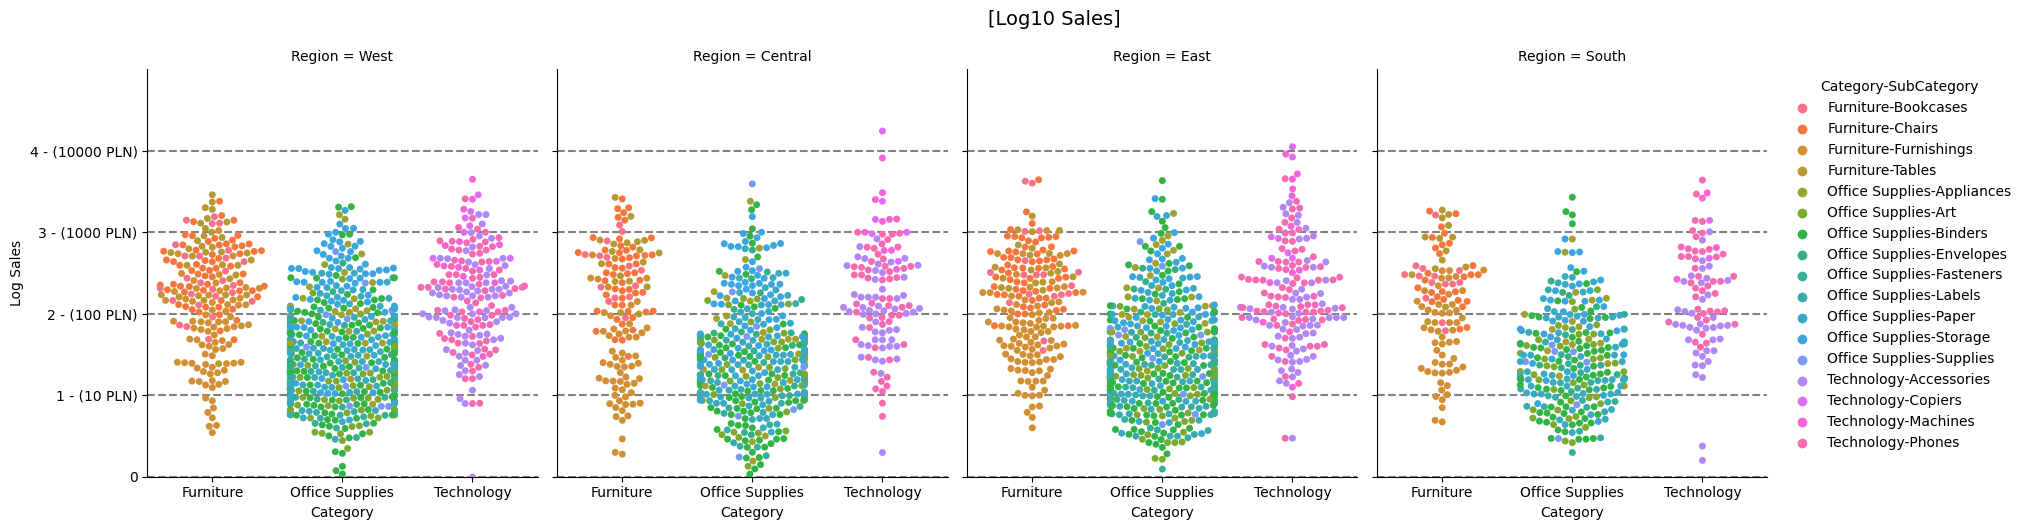

In [36]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Log Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
)
g.set(ylim=(0, 5))
g.fig.suptitle(f"[Log10 Sales]", fontsize=14, y=1.05)

g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
# Move the legend outside the chart box
# Add horizontal lines at each ytick
for ax in g.axes.flat:
    yticks = ax.get_yticks()
    for ytick in yticks:
        ax.axhline(ytick, color='gray', linestyle='--')


2014
2015
2016
2017


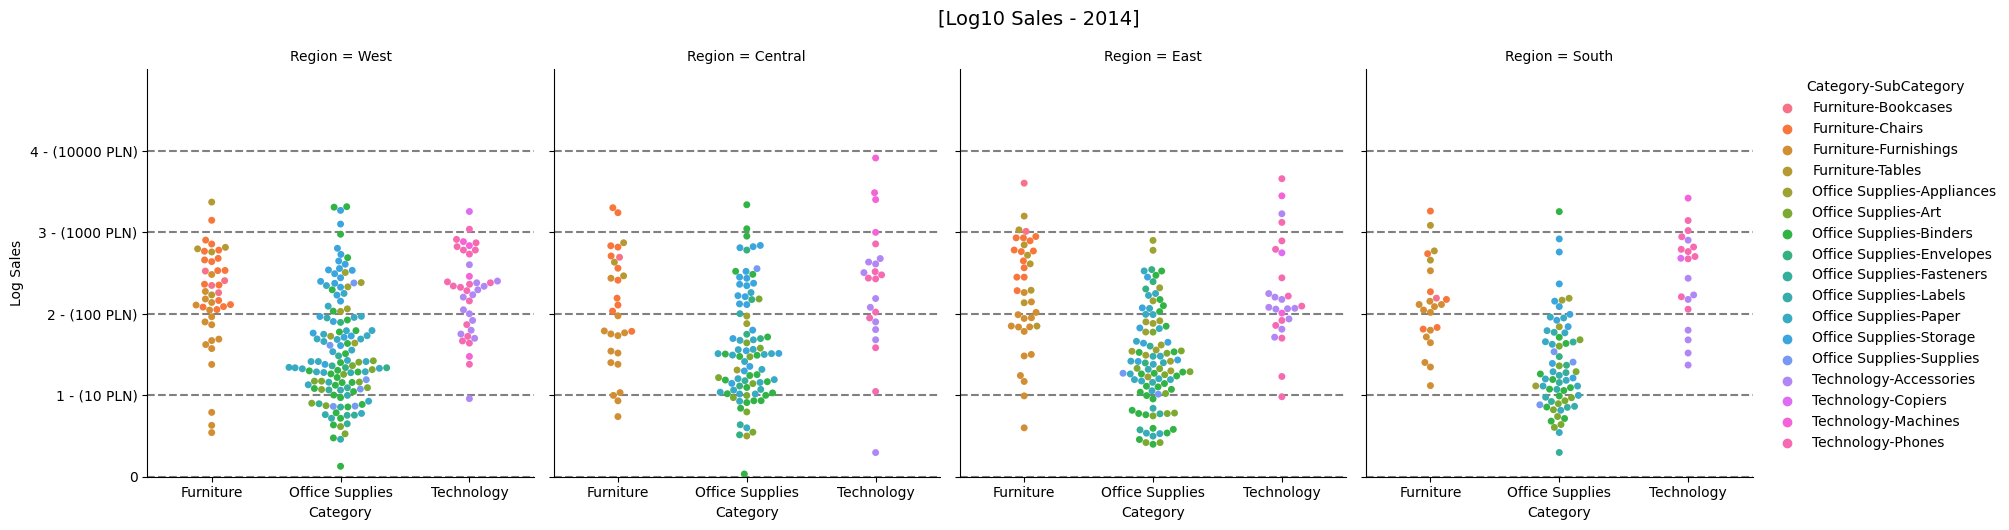

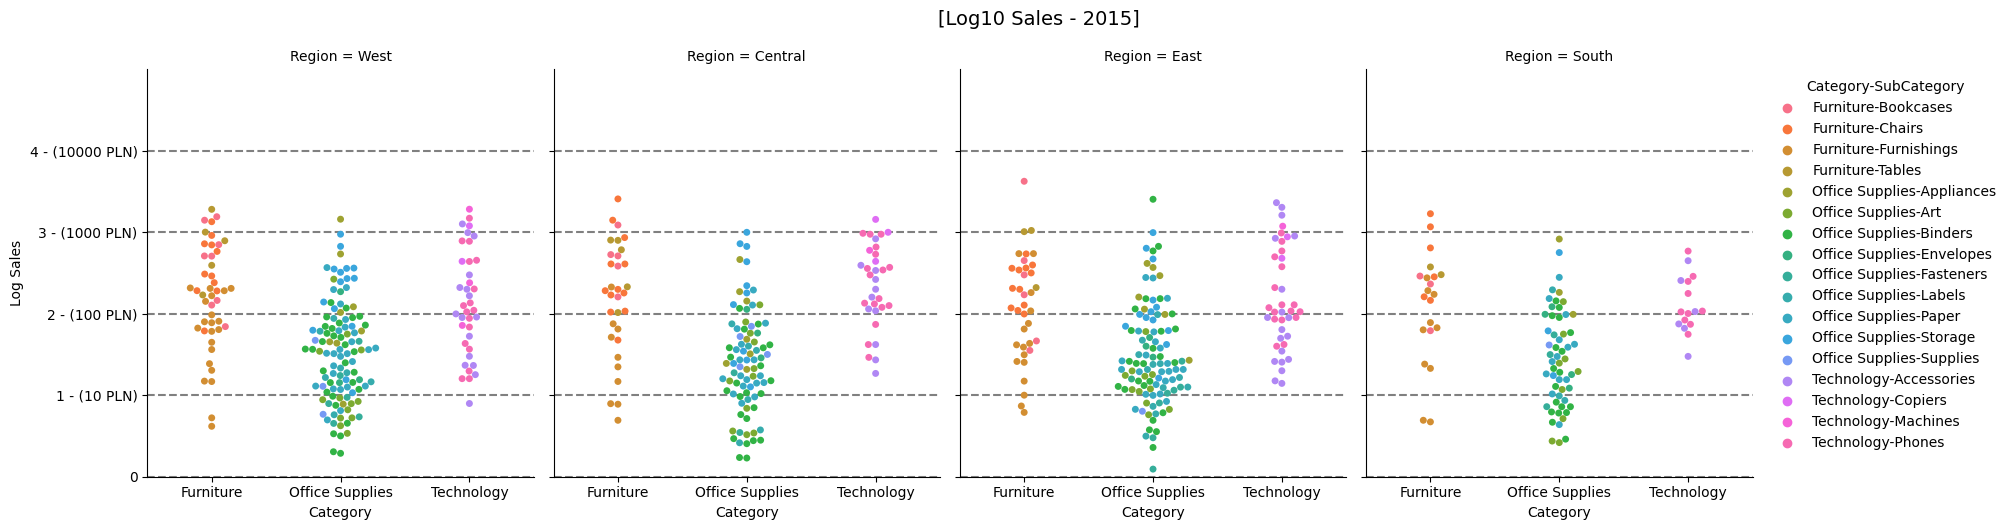

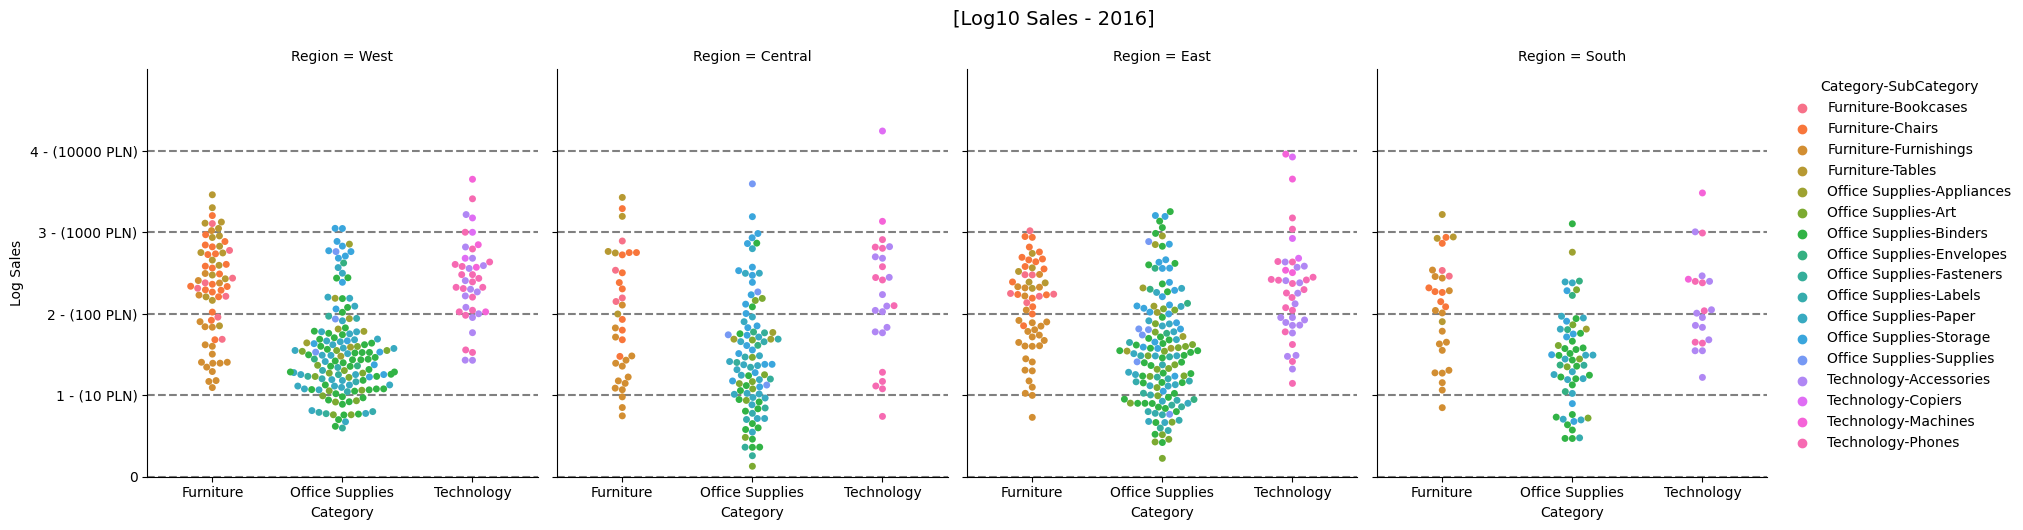

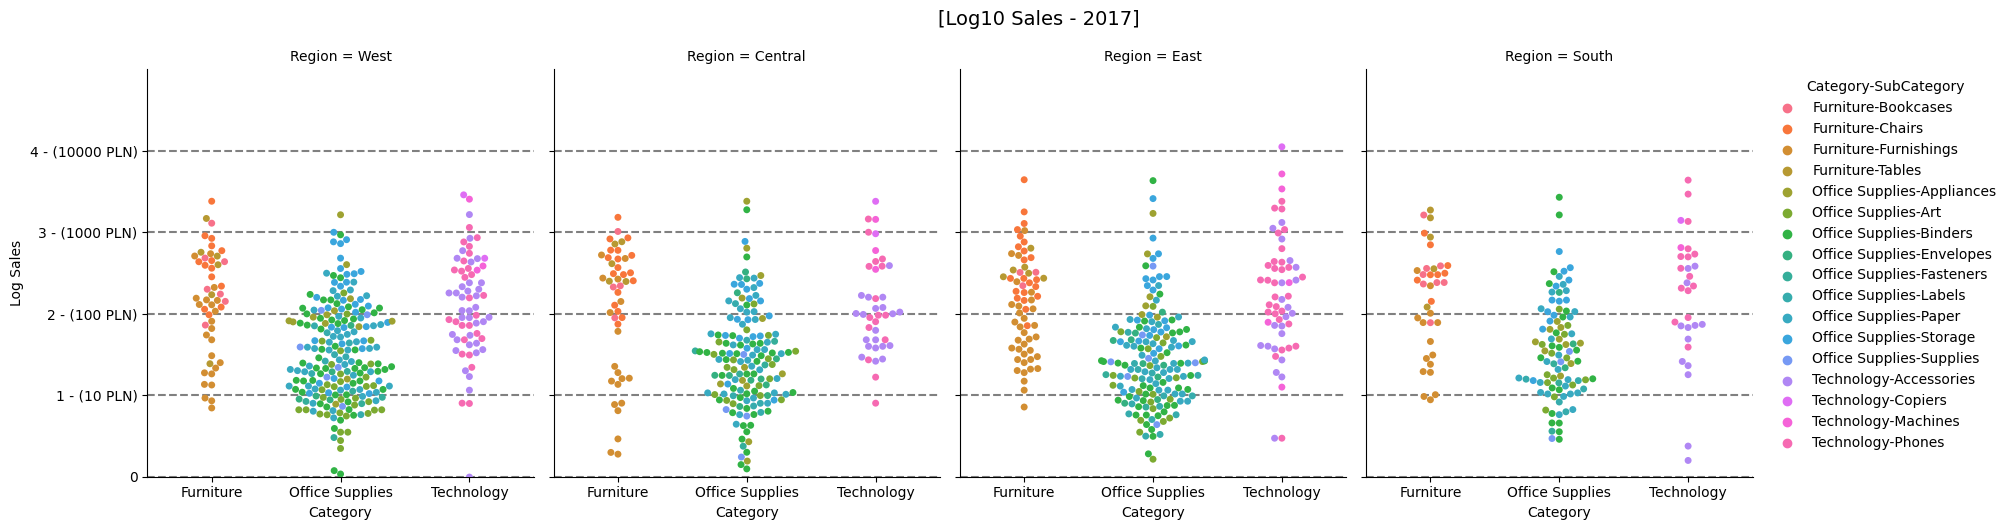

In [37]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Log Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region", col_order=COL_ORDER, aspect=.85
    )
    g.set(ylim=(0, 5))
    g.fig.suptitle(f"[Log10 Sales - {v}]", fontsize=14, y=1.05)
    
    g.set(yticks=[0, 1, 2, 3, 4], yticklabels=["0", "1 - (10 PLN)", "2 - (100 PLN)", "3 - (1000 PLN)", "4 - (10000 PLN)"])
    # Move the legend outside the chart box
    # Add horizontal lines at each ytick
    for ax in g.axes.flat:
        yticks = ax.get_yticks()
        for ytick in yticks:
            ax.axhline(ytick, color='gray', linestyle='--')

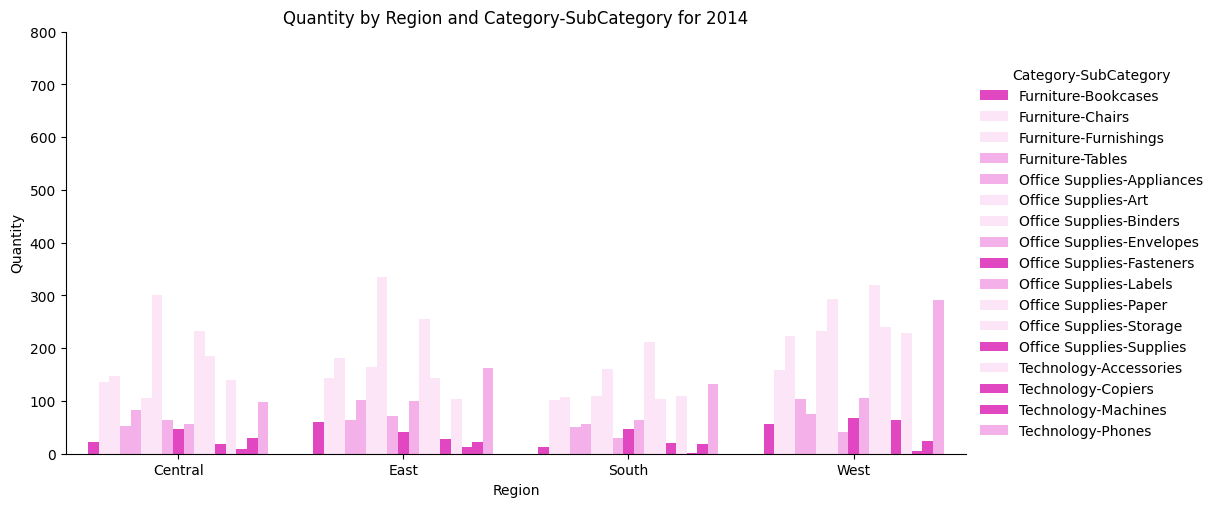

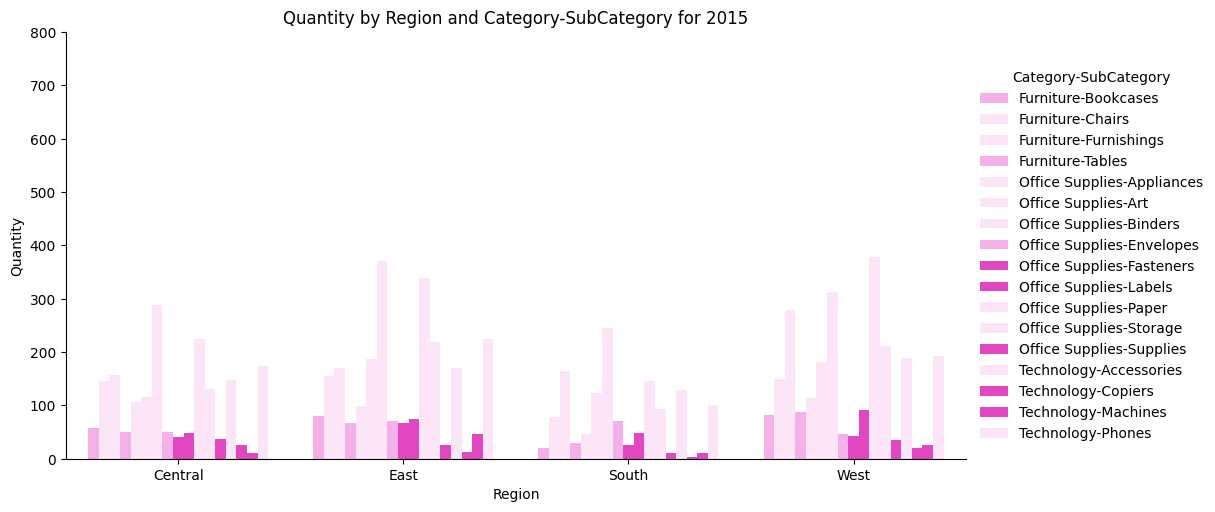

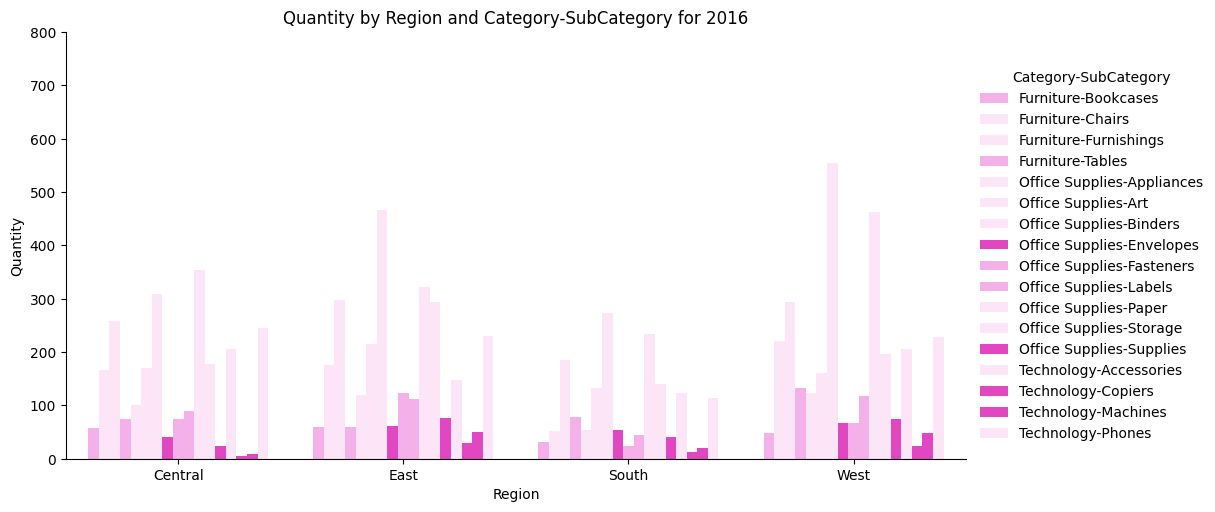

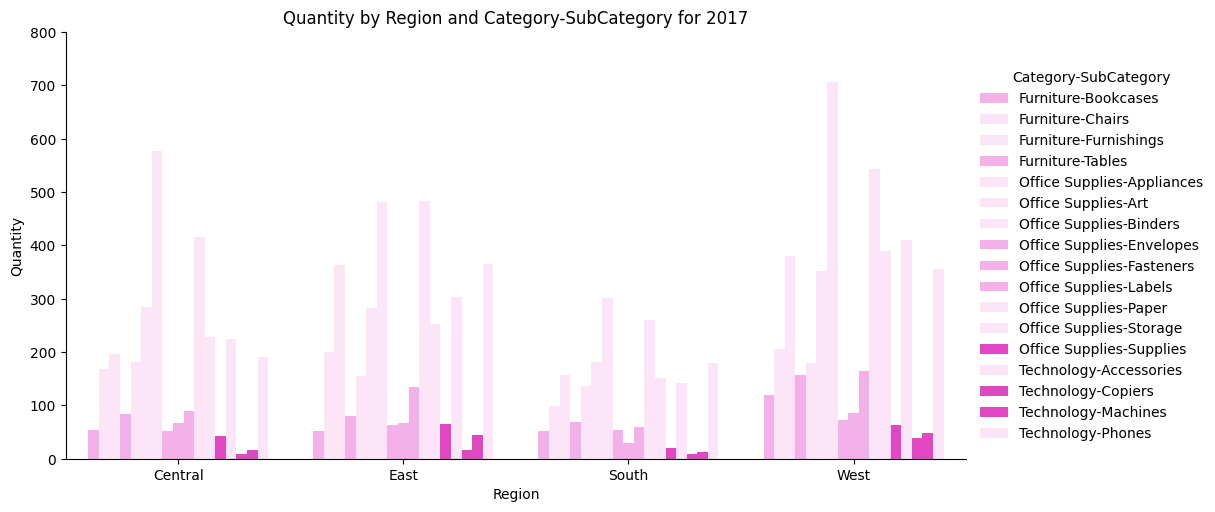

In [38]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 50:
            colors.append('#FA2DD0') # Light red
        elif value < 100:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Quantity': 'sum', 'Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Quantity'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Quantity', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 800))
    plt.title(f'Quantity by Region and Category-SubCategory for {year}')
    plt.show()


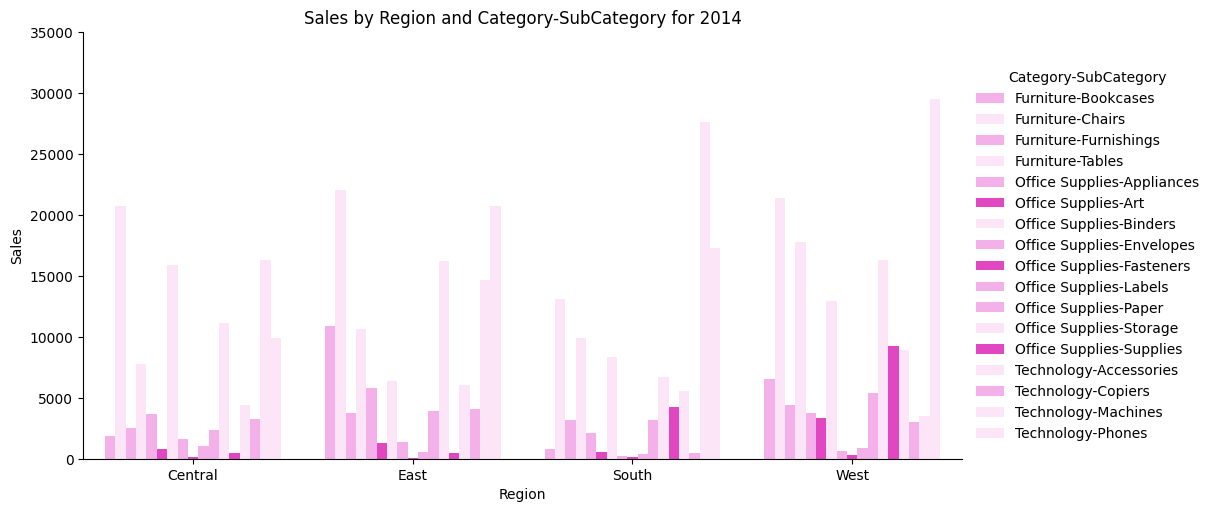

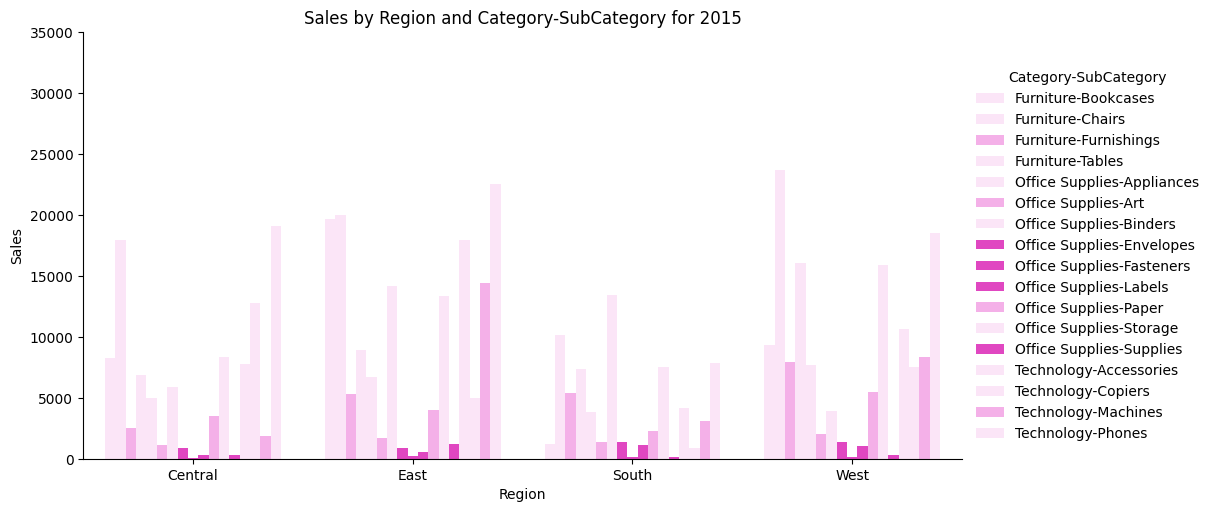

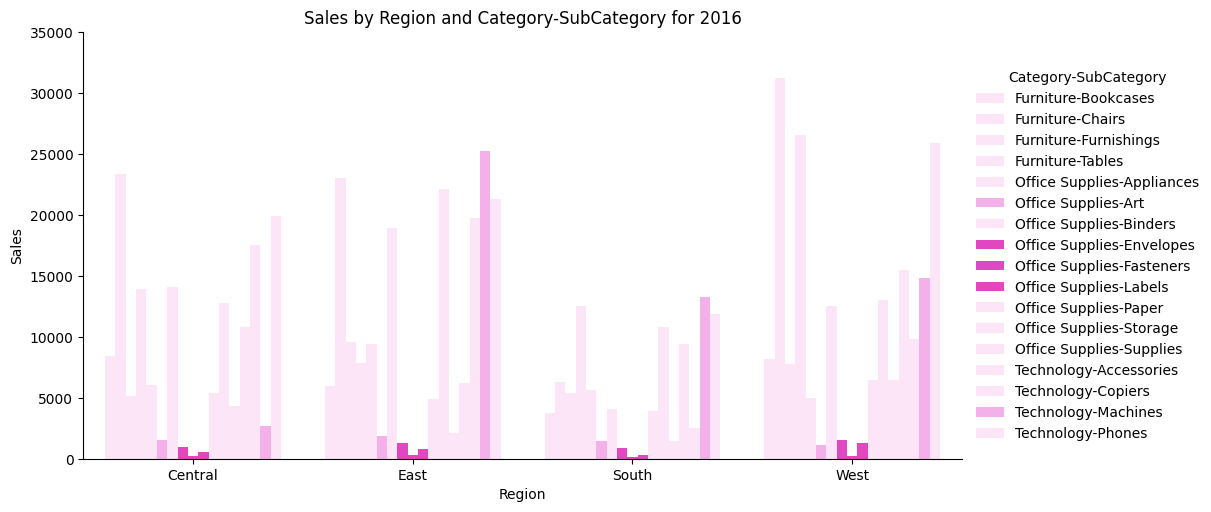

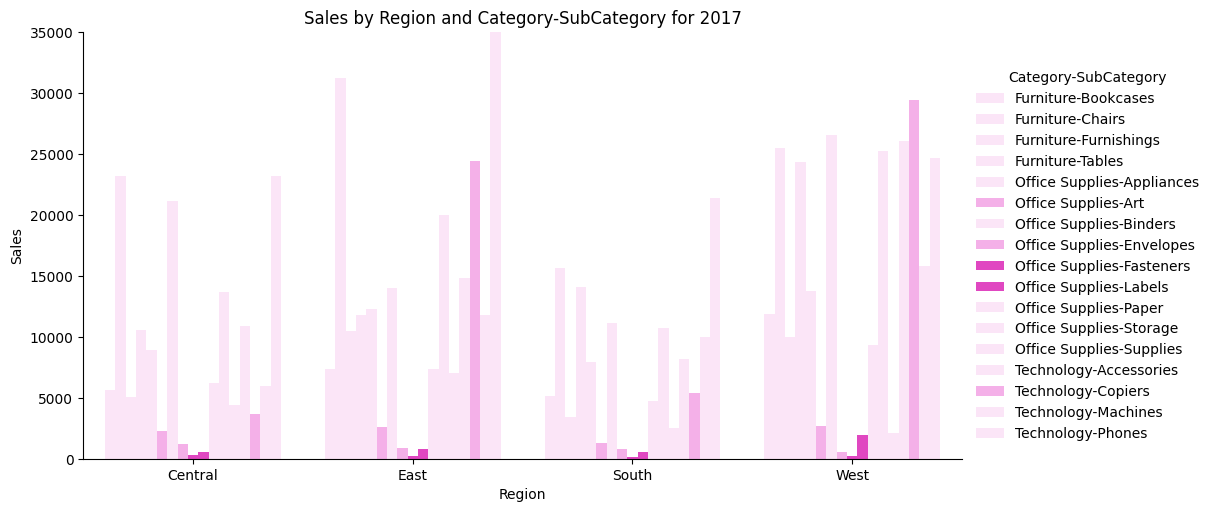

In [39]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 1000:
            colors.append('#FA2DD0') # Light red
        elif value < 4000:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Sales'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Sales', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 35000))
    plt.title(f'Sales by Region and Category-SubCategory for {year}')
    plt.show()


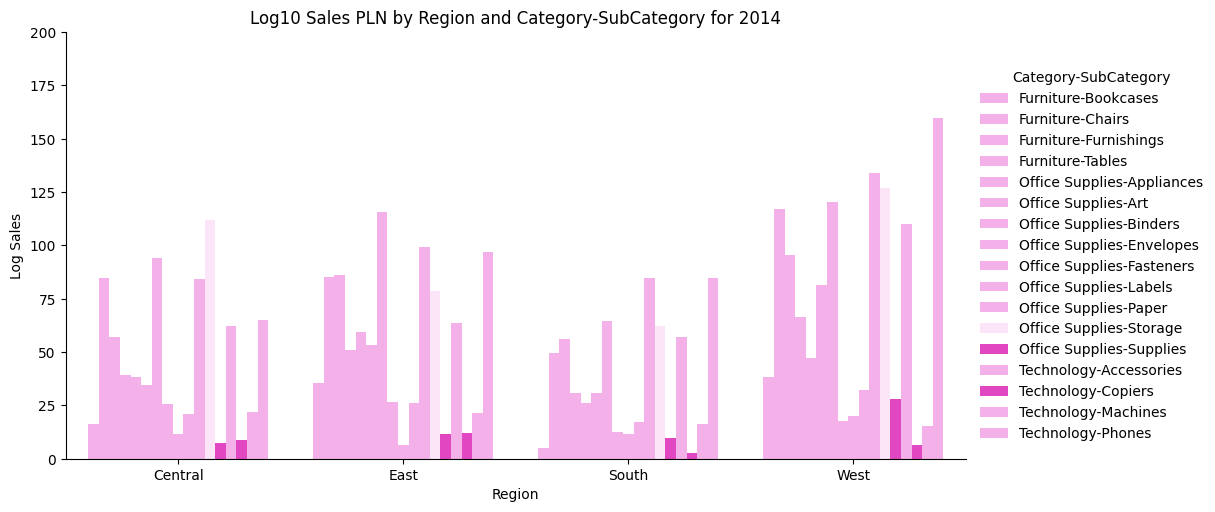

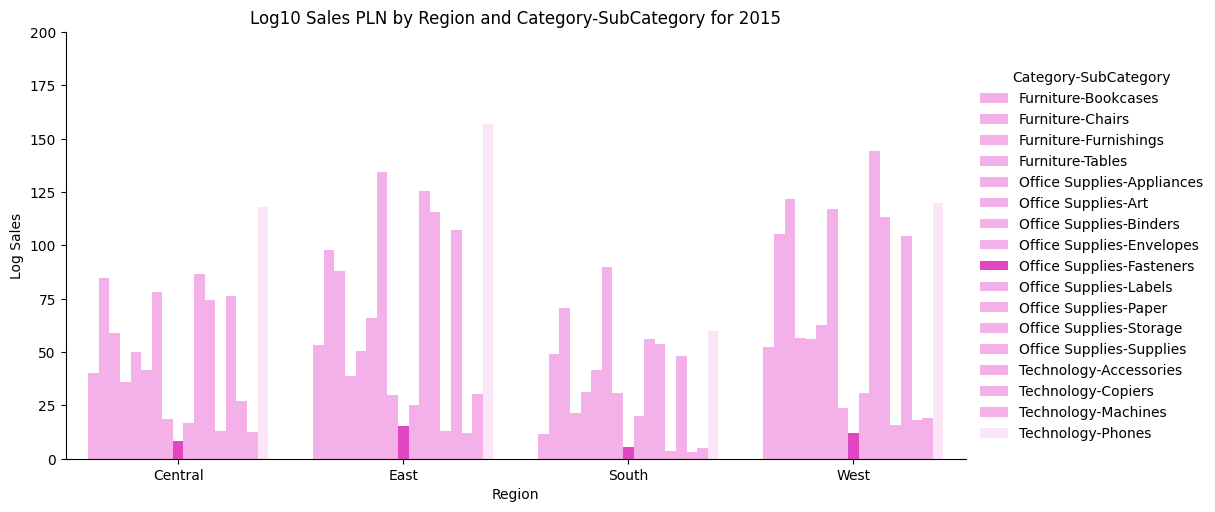

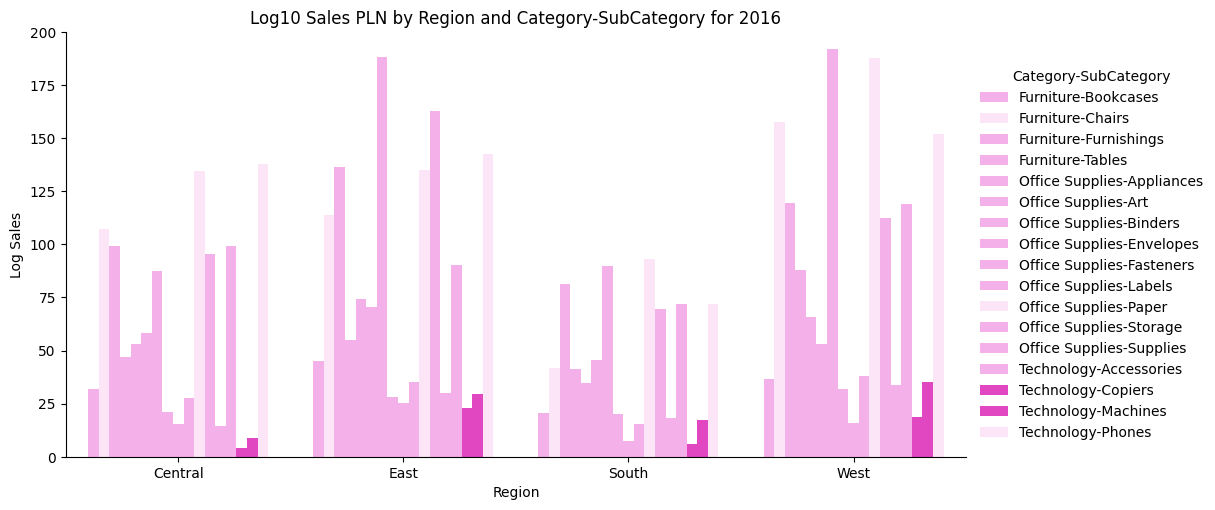

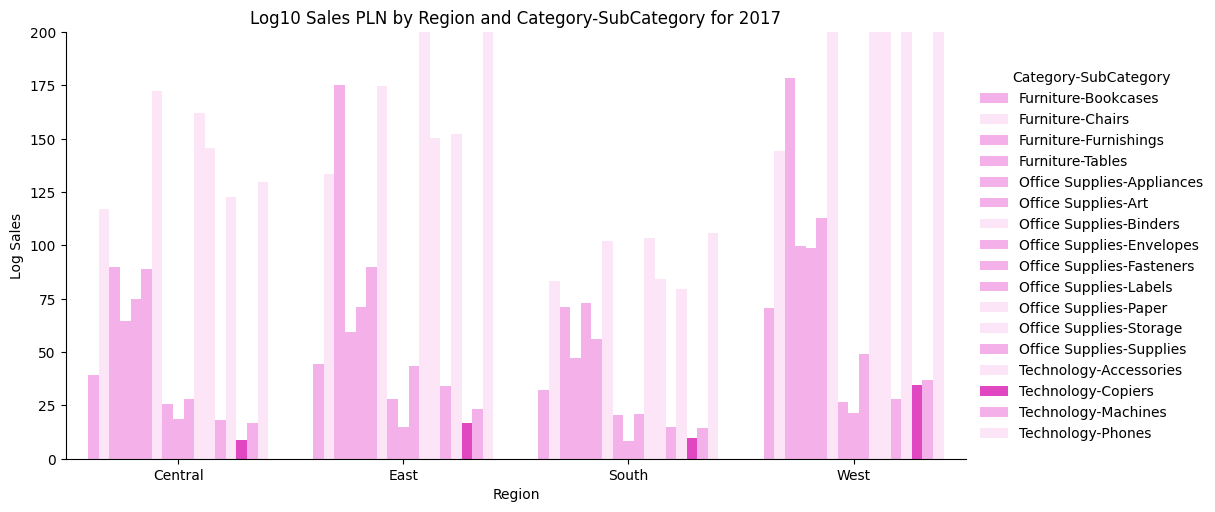

In [40]:
import seaborn as sns

# Define the function to generate a custom color palette
def color_palette(data, variable):
    colors = []
    for value in data[variable]:
        if value < 10:
            colors.append('#FA2DD0') # Light red
        elif value < 100:
            colors.append('#FFA5F0') # Medium red
        else:
            colors.append('#FFE1FA') # Dark red
    return colors

# Loop through the years and create the bar charts
for year in sorted(df['Order Year'].unique()):
    data = df[df['Order Year'] == year]
    pivot_table = data.groupby(['Region', 'Category-SubCategory']).agg({'Log Sales': 'sum'}).reset_index()

    # Set the color of the bars based on the Sales column
    my_palette = sns.color_palette(color_palette(pivot_table, 'Log Sales'))

    # Plot Sales by Region and SubCategory
    g = sns.catplot(data=pivot_table, x='Region', y='Log Sales', hue='Category-SubCategory', hue_order=HUE_ORDER, kind='bar', height=5, aspect=2, palette=my_palette)
    g.set(ylim=(0, 200))
    plt.title(f'Log10 Sales PLN by Region and Category-SubCategory for {year}')
    plt.show()


# Yearly Sales

# Quarterly Sales

# Monthly Sales

AttributeError: 'NaTType' object has no attribute 'normalize'

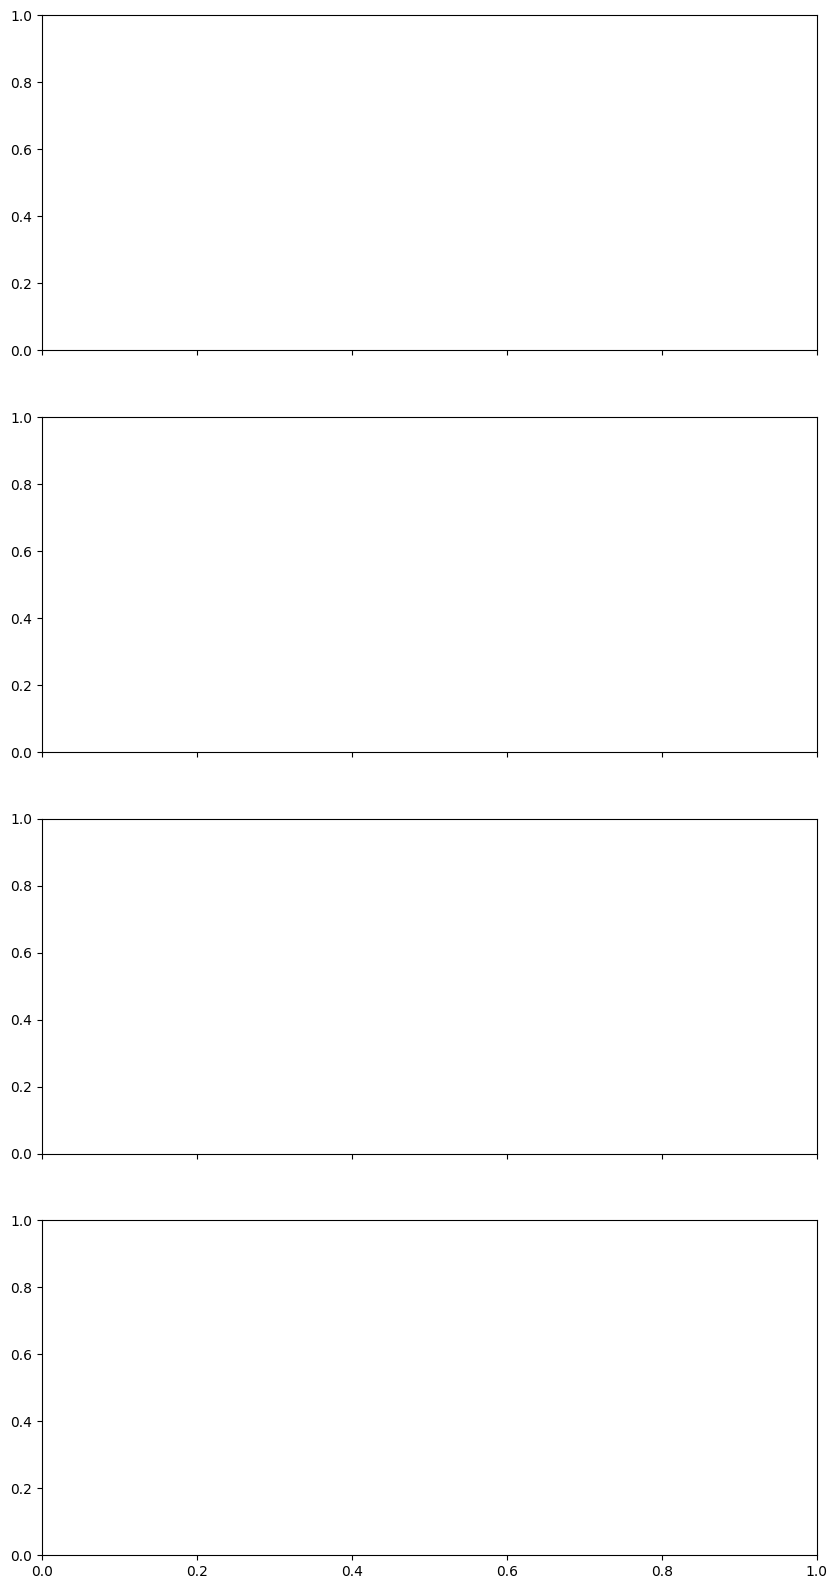

In [139]:
# Replace missing or invalid datetime values with the minimum datetime value in the column
df_timeseries["Order Date"] = df_timeseries["Order Date"].fillna(df_timeseries["Order Date"].min())

# Define the categories and regions
categories = df_timeseries["Category"].unique()
regions = df_timeseries["Region"].unique()

# Create subplots for each region
fig, axs = plt.subplots(len(regions), 1, figsize=(10, 20), sharex=True)

# Loop through each region
for i, region in enumerate(regions):
    # Select the data for the current region
    region_data = df_timeseries[df_timeseries["Region"] == region]
    # Loop through each category
    for j, category in enumerate(categories):
        # Select the data for the current category in the current region
        category_data = region_data[region_data["Category"] == category]
        # Group the data by month and calculate the sum
        monthly_data = category_data.groupby(pd.Grouper(freq='M', key='Order Date'))['Log Sales'].sum()
        # Plot the monthly sales line chart
        axs[i].plot(monthly_data.index, monthly_data, label=category)

    # Set the title and y-axis label for the subplot
    axs[i].set_title(f"{region}")
    axs[i].set_ylabel("Log10 Sales PLN")
    axs[i].set(ylim=(0, 50))
    # Add horizontal lines at y=0.5 and y=10
    axs[i].axhline(y=0.5, color='r', linestyle='--')
    axs[i].axhline(y=10, color='gray', linestyle='--')
    # Add the legend for the subplot
    axs[i].legend(loc="upper left")

# Set the x-axis label and title for the whole figure
plt.xlabel("Date")
fig.suptitle("Monthly Log10 Sales PLN by Category and Region", fontsize=14, y=0.92)

# Display the plot
plt.show()


In [105]:
df

Order ID       Ship Mode   Region       Product ID  \
Order Date                                                             
2015-12-12  PL-2015-110870     First Class     West  TEC-AC-10002926   
2015-12-12  PL-2015-110870     First Class     West  OFF-SU-10001225   
2014-12-01  PL-2014-143210     First Class     East  TEC-PH-10004434   
2014-12-01  PL-2014-143210     First Class     East  FUR-FU-10003878   
2014-12-01  PL-2014-143210     First Class     East  FUR-FU-10002268   
2016-10-07  PL-2016-139808  Standard Class     West  OFF-FA-10001883   
2015-11-17  PL-2015-110863  Standard Class  Central  OFF-ST-10002756   
2015-11-17  PL-2015-110863  Standard Class  Central  OFF-PA-10000474   
2015-11-17  PL-2015-110863  Standard Class  Central  FUR-CH-10002073   
2014-03-17  PL-2014-127859    Second Class     East  OFF-PA-10003641   
2015-06-20  SL-2015-136427     First Class     West  TEC-PH-10002070   
2017-05-25  PL-2017-120168        Same Day     East  OFF-BI-10004519   
2017-05-25  PL-2017-120168        Same Day     East  TEC-AC-10002167   
2017-05-25  PL-2017-120168        Same Day     East  OFF-FA-10000936   
2017-05-25  PL-2017-120168        Same Day     East  FUR-FU-10000732   
2014-09-09  SL-2014-131870     First Class     East  FUR-FU-10002501   
2014-09-09  SL-2014-131870     First Class     East  OFF-AR-10000634   
2017-10-17  PL-2017-114804    Second Class     West  TEC-PH-10001700   
2017-11-02  PL-2017-167227     First Class  Central  OFF-AP-10001962   
2017-11-02  PL-2017-167227     First Class  Central  OFF-PA-10001838   
2014-07-21  PL-2014-129189  Standard Class  Central  OFF-AP-10000124   
2014-07-21  PL-2014-129189  Standard Class  Central  OFF-EN-10003567   
2014-07-21  PL-2014-129189  Standard Class  Central  FUR-CH-10004997   
2014-07-21  PL-2014-129189  Standard Class  Central  OFF-BI-10000494   
2015-09-11  PL-2015-132465    Second Class     East  FUR-FU-10000277   
...                    ...             ...      ...              ...   
2015-08-16  SL-2015-126753  Standard Class     East  OFF-BI-10003727   
2015-08-16  SL-2015-126753  Standard Class     East  OFF-PA-10000130   
2014-05-31  PL-2014-166051  Standard Class    South  TEC-PH-10002680   
2014-05-31  PL-2014-166051  Standard Class    South  TEC-PH-10002538   
2015-08-27  PL-2015-113040  Standard Class     West  OFF-BI-10001249   
2014-01-03  PL-2014-103800  Standard Class  Central  OFF-PA-10000174   
2014-09-10  PL-2014-113383     First Class     East  OFF-AP-10004532   
2014-09-10  PL-2014-113383     First Class     East  FUR-FU-10001986   
2017-01-22  PL-2017-152499    Second Class  Central  OFF-FA-10002975   
2017-01-22  PL-2017-152499    Second Class  Central  OFF-AR-10003481   
2016-04-21  PL-2016-151498     First Class     West  OFF-BI-10004967   
2016-07-20  PL-2016-137939    Second Class     East  TEC-PH-10003589   
2016-08-23  SL-2016-117793  Standard Class  Central  OFF-LA-10002945   
2016-08-23  SL-2016-117793  Standard Class  Central  OFF-LA-10003537   
2016-08-23  SL-2016-117793  Standard Class  Central  OFF-ST-10002406   
2016-08-23  SL-2016-117793  Standard Class  Central  TEC-AC-10003433   
2016-06-14  PL-2016-133872     First Class    South  OFF-BI-10002082   
2016-06-14  PL-2016-133872     First Class    South  TEC-AC-10000521   
2015-11-20  SL-2015-165743    Second Class     West  OFF-BI-10001982   
2015-11-20  SL-2015-165743    Second Class     West  FUR-BO-10002268   
2015-11-20  SL-2015-165743    Second Class     West  OFF-BI-10001758   
2017-11-03  SL-2017-105998     First Class     West  TEC-AC-10004469   
2017-11-03  SL-2017-105998     First Class     West  FUR-TA-10001095   
2014-05-04  SL-2014-148194     First Class     West  FUR-FU-10001852   
2014-05-04  SL-2014-148194     First Class     West  OFF-AP-10000696   

                   Category Sub-Category  \
Order Date                                 
2015-12-12       Technology  Accessories   
2015-12-12  Office Supplies     Supplies   
2014-12-01       Technolo

# SQL

In [45]:
conn = connect(':memory:')
df.to_sql('data', conn)

9993

# General view

In [48]:
agg_data = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [49]:
# furniture_pivot = pd.pivot_table(furniture, values='Count', index=['Order Year', 'Category'],
#                           columns=['Order Month'], aggfunc=sum, fill_value=0)

In [50]:
# furniture_pivot

In [51]:
# # iterate over the multi-index
# for index, group in furniture_pivot.groupby(level=['Order Year', 'Category']):
# #     print('Order Year:', index[0])
#     print('Category:', index[1])
# #     print(group)

In [52]:
agg_data_pivot = pd.pivot_table(agg_data, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [53]:
agg_data_pivot

Order Month   01   02   03   04   05   06   07   08    09    10    11    12
Order Year                                                                 
2014         284  159  585  536  466  521  550  609  1000   573  1219  1079
2015         236  239  515  543  575  486  557  598  1086   631  1306  1203
2016         358  306  579  635  863  742  758  693  1316   767  1406  1414
2017         597  363  885  733  887  931  840  884  1660  1133  1840  1723

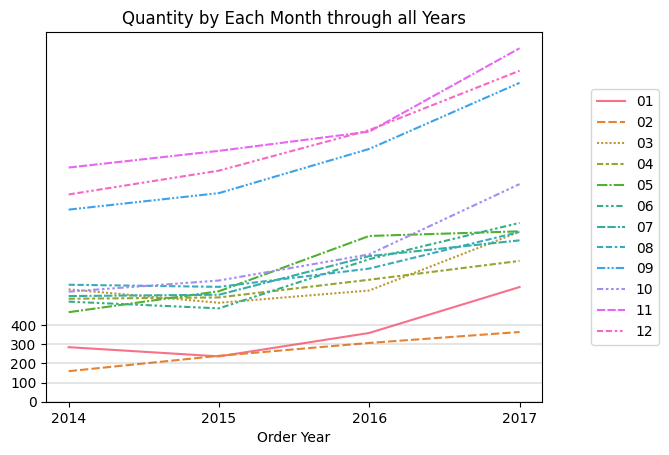

In [54]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Quantity by Each Month through all Years")
ax.set_yticks(list(range(0, 500, 100)))
for y in range(0, 500, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [55]:
agg_data_pivot = pd.pivot_table(agg_data, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

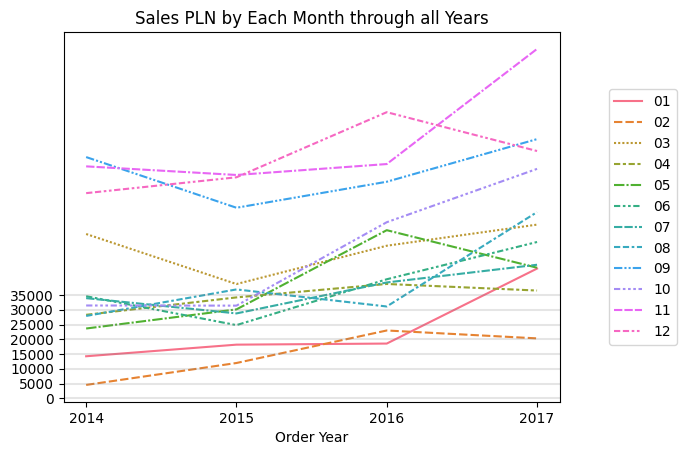

In [56]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Sales PLN by Each Month through all Years")
ax.set_yticks(list(range(0, 40000, 5000)))
for y in range(0, 40000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [57]:
agg_data_pivot = pd.pivot_table(agg_data, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

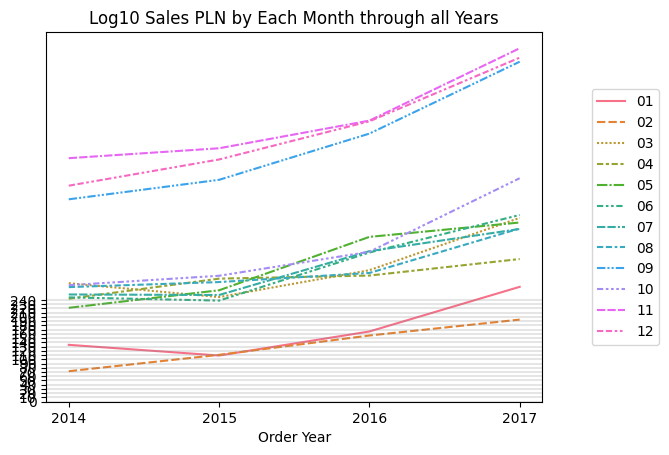

In [58]:
ax = sns.lineplot(data=agg_data_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Log10 Sales PLN by Each Month through all Years")
ax.set_yticks(list(range(0, 250, 10)))
for y in range(0, 250, 10):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

# Technology

In [59]:
technology = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Technology')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [60]:
technology_pivot = pd.pivot_table(technology, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [61]:
technology_pivot

Order Month   01  02   03   04   05   06   07   08   09   10   11   12
Order Year                                                            
2014          45  33   84  110   88   77  103  126  168  111  250  194
2015          38  45   90  138   87   78  102  116  196  136  197  262
2016          72  53  130   81  161  124  126  135  198  115  269  234
2017         116  70  205   90  159  189  198  144  312  229  383  268

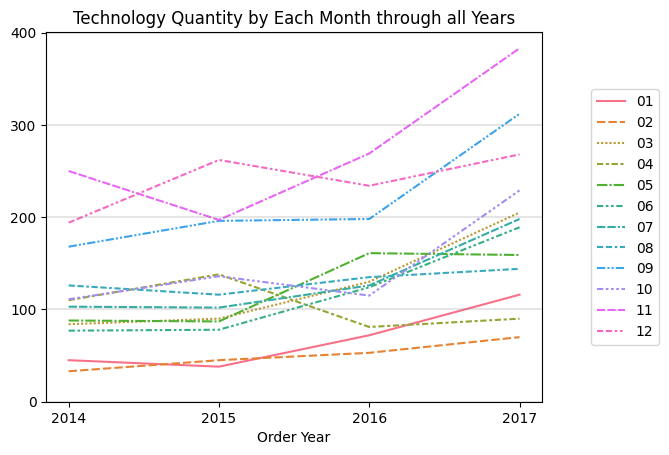

In [62]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Quantity by Each Month through all Years")
ax.set_yticks(list(range(0, 500, 100)))
for y in range(0, 500, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [63]:
technology_pivot = pd.pivot_table(technology, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

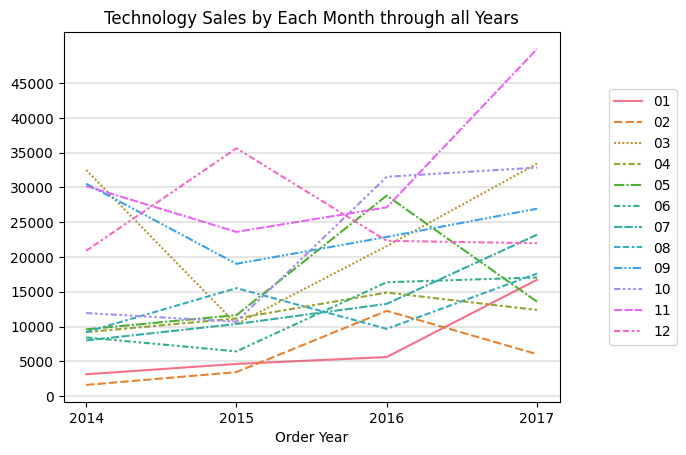

In [64]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Sales by Each Month through all Years")
ax.set_yticks(list(range(0, 50000, 5000)))
for y in range(0, 50000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [65]:
technology_pivot = pd.pivot_table(technology, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

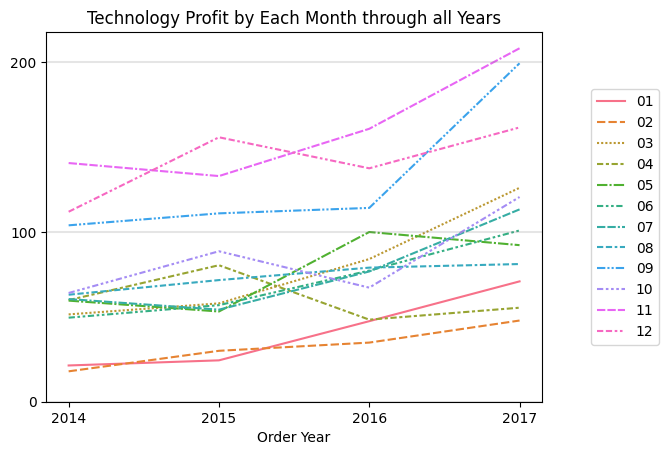

In [66]:
ax = sns.lineplot(data=technology_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Technology Profit by Each Month through all Years")
ax.set_yticks(list(range(0, 250, 100)))
for y in range(0, 250, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

# Office supplies

In [67]:
office_supplies = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Log Sales") AS LogSales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Office Supplies')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [68]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Quantity', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

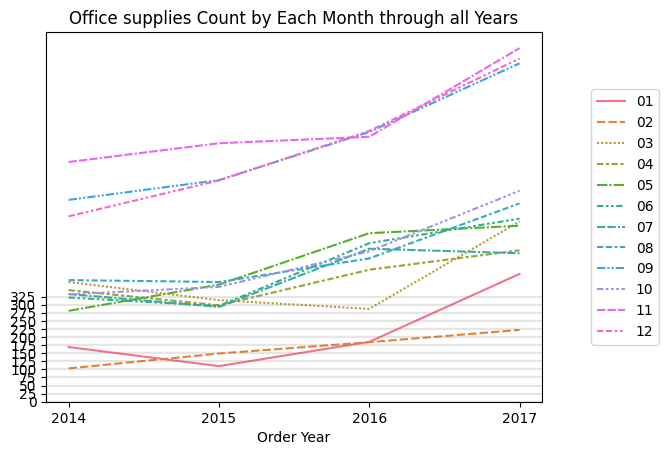

In [69]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Count by Each Month through all Years")
ax.set_yticks(list(range(0, 350, 25)))
for y in range(0, 350, 25):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [70]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

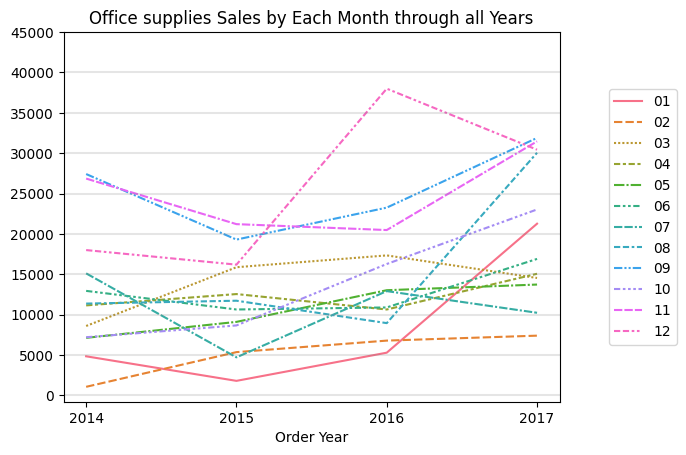

In [71]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Sales by Each Month through all Years")
ax.set_yticks(list(range(0, 50000, 5000)))
for y in range(0, 50000, 5000):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()

In [72]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='LogSales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

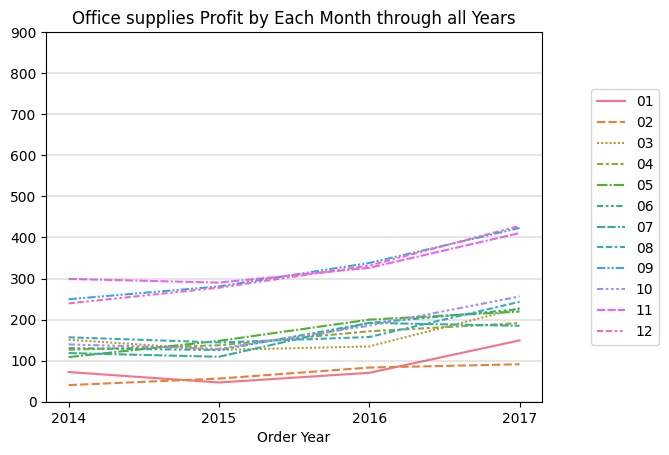

In [73]:
ax = sns.lineplot(data=office_supplies_pivot)

# Move the legend
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

# Add title and y-axis ticks
ax.set_title("Office supplies Profit by Each Month through all Years")
ax.set_yticks(list(range(0, 1000, 100)))
for y in range(0, 1000, 100):
    ax.axhline(y=y, linestyle='-', color='gray', alpha=0.2)

# Show the plot
plt.show()